In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from tqdm import tqdm
import warnings

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = 8,4
warnings.filterwarnings('ignore')

In [3]:
########### FUNCIONES ÚTILES ############

# Se normalizarán las columnas para trabajar solo en minúsculas
def normalize_table(df):
    df.columns = [x.lower() for x in df]
    
    
def eda_get_memory(df):
    """Retorna un string con el tamaño de un dataframe en Mb"""
    memSizeMb = df.memory_usage().sum()/1024/1024*1000//10/100
    return f'{memSizeMb} Mb'

def eda_describe_df(df=None, print_cols=False):
    """This function checks all the columns of the dataset and shows a summary of all the column descriptors. 
    It is an improvement to the df.describe() function and it helps to identify the key columns.
    
    Parameters
    ----------
        df (pd.DataFrame): Dataframe to analyze
        print_cols (bool): Print the columns if True
    
    Returns
    -------
        df_describe (pd.DataFrame): Summary of the analysis of the original dataset
    """
    df_describe = pd.DataFrame()
    print(f'Shape:\t{df.shape}')
    print(f'Memory:\t{eda_get_memory(df)}')
    if print_cols: 
        print(f'Cols:\t {sorted(list(df))}')
    nrows = len(df)
    for feature in tqdm(list(df)):
        serie = df[feature]
        describe = {}
        describe['feature'] = feature
        describe['nunique'] = serie.nunique()
        describe['total_nulls'] = serie.isnull().sum()
        describe['nulos_perc'] = describe['total_nulls'] / nrows
        describe['total_notnulls'] = serie.count()
        describe['dtype'] = str(serie.dtype)
        describe['mode'] = ((((serie.value_counts(dropna=False).head(1))/(df.shape[0]))*10000//1/100).map(str)+'% of rows').to_dict()
        describe['mode_freq'] = (serie.value_counts(dropna=False)/(df.shape[0])).values[0]
        if describe['dtype'][:3] in ['int','flo','num']:
            describe['mean'] = serie.mean()
            describe['std'] = serie.std()
            describe['min'] = serie.min()
            describe['max'] = serie.max()
            describe['skewness'] = serie.skew()
            describe['kurtosis'] = serie.kurtosis()
            describe['top3values'] = serie.nlargest(3).to_list()
            describe['p05'] = serie.quantile(0.05)
            describe['p10'] = serie.quantile(0.10)
            describe['p25'] = serie.quantile(0.25)
            describe['p50'] = serie.quantile(0.50)
            describe['p75'] = serie.quantile(0.75)
            describe['p90'] = serie.quantile(0.90)
            describe['p95'] = serie.quantile(0.95)
        else:
            for desc_val in ['mean','std','min','max','skewness','kurtosis',
                            'top3values','p05','p10','p25','p50','p75','p90','p95']:
                describe[desc_val] = np.nan
                
        df_i = pd.DataFrame([describe])
        df_describe = df_describe.append(df_i).reset_index(drop=True)
    df_describe = df_describe.sort_values('nunique', ascending=False)
    df_describe = df_describe.set_index('feature').T#fillna('').T
    return df_describe

In [4]:
def get_feature_corrected(data, feature, prefix='corrected'):
    '''Get Feature Corrected
    This function checks each value of a time series and evaluates if the serie makes sense.
    If not (eg: when there is an anormal increase or reduction), it corrects the value.
    
    Parameters
    ----------
        data (pd.DataFrame): Dataset with the banking feature
        feature (str): Feature to be corrected
        prefix (str): Prefix to be added in the newly generated column (corrected)
    
    Returns
    -------
        None, but it creates a feature where correction is applied
    
    '''
    corrected_curve = []
    last_value = 0
    for row in data[feature]:
        if str(row) == 'nan' or row == 0: # If registry is null, keep it null
            corrected_curve.append(row)
        elif last_value == 0:             # If it is the first value, take it
            corrected_curve.append(row)
            last_value = row
        else:                             # Otherwise, evaluate the ratio and make corrections 
            ratio = row / last_value
            exp10 = round(np.log10(ratio * 1000),0) - 3
            new_row_value = row / 10**exp10
            
            last_value = new_row_value
            corrected_curve.append(new_row_value)
    banco_central[f'{prefix}_{feature}'] = corrected_curve

# Data Loading

Cargar archivo precipitaciones.csv con las precipitaciones medias mensuales
registradas entre enero 1979 y abril 2020. (Unidad: mm).

Cargar archivo banco_central.csv con variables económicas.

In [5]:
precipitacion = pd.read_csv('./precipitaciones.csv')
banco_central = pd.read_csv('./banco_central.csv')
precio_leche = pd.read_csv('./precio_leche.csv')

normalize_table(precipitacion)
normalize_table(banco_central)
normalize_table(precio_leche)

# Exploratory Data Analysis

- Realiza un análisis exploratorio de la base de datos, ¿Qué puedes decir de los datos,
sus distribuciones, valores faltantes, otros? ¿Hay algo que te llame la atención?

- Realiza una limpieza de datos para que las series de tiempo no tengan duplicados ni
valores incorrectos.

__COMENTARIOS__

__Precipitaciones__
- No hay datos duplicados ni nulos. Hay registros mensuales desde 1979 hasta 2020.
- El dataset contiene la fecha y la precipitación en mm de 8 ciudades.
- No es necesaria una limpieza especial. Solamente se ubica el periodo como indice y se le ordena para trabajar con Series de Tiempo
- La data de precipitaciones refleja estacionariedad con ciclos anuales que se repiten ligeramente. Es posible identificar periodos lluviosos (medio año) y periodos secos (inicio y fin de año)
- Se puede ver que en el tiempo la tendencia de las precipitaciones va a la baja (probablemente por el cambio climático)


__Banco Central__
- Existen 2 registros duplicados, y un registro con un mes 13 que se eliminó. Además algunos features que deberían ser numéricos, eran "objects" debido a la presencia de puntos "." y letras ("a") en su contenido.
- Después de limpiar los caracteres no numéricos de las features, se tienen todas las curvas bancarias.
- Las curvas tienen inicios de registro distintas, mientras algunas inician en 1970, una mayoría inicia recién entre 2013 y 2014.
- Las curvas resultado de la limpieza mostraban una volatilidad bastante inusual, por lo que se interpretó que había un error de carga de datos donde se habrían subido los números correctos, pero con una escala equivocada. Esto se infirió pues registros contiguos mostraban cambios del orden del 1:10:100. 
- Después de generar una función para limpiar este error de escala, las nuevas curvas corregidas muestran un mucho mejor comportamiento. Así también, presentan estacionalidades que antes dificilmente serían reconocidas.
- Así como los datos tenían inicios de registro distintos, los fines de registro no eran iguales. Las curvas no llegaban a los periodos más recientes de la curva de precio de la leche, por ejemplo. --> Se solucionó imputando features. 
- Algo interesante era que algunas curvas de PIB tenían una relación bastante acorde con las precipitaciones, como el PIB agrario, que era muy ciclico y se movía a la par que las precipitaciones (cuando uno es alto, el otro es bajo).

## Precipitaciones

### EDA Inicial

In [6]:
# Sample inicial
precipitacion.sample(5)

date   coquimbo  valparaiso  metropolitana_de_santiago  \
37   1986-11-01   0.352732    5.321136                  13.966846   
98   1992-04-01  26.415569   48.485617                  84.938154   
402  1983-09-01  11.138196   26.274318                  50.929346   
163  2010-10-01   1.939399   12.844692                  20.237399   
440  2002-11-01   0.064993    0.871234                   4.812483   

     libertador_gral__bernardo_o_higgins       maule      biobio  \
37                             42.749954  112.497113  179.713304   
98                             83.563364  107.380840  159.531137   
402                            72.709380   85.390125  125.519495   
163                            30.954589   49.345017   67.326828   
440                             8.068775   28.771206  104.193477   

     la_araucania    los_rios  
37     234.542011  270.261538  
98     183.240251  229.846577  
402    165.941112  275.676421  
163    112.109909  156.815762  
440    174.743862  249.310530

In [7]:
# Obtenemos un resumen del dataset (df.describe() mejorado)
eda_describe_df(precipitacion)

Shape:	(496, 9)
Memory:	0.03 Mb


100%|██████████| 9/9 [00:00<00:00, 113.10it/s]


feature                                   date  \
nunique                                    496   
total_nulls                                  0   
nulos_perc                                 0.0   
total_notnulls                             496   
dtype                                   object   
mode            {'1989-02-01': '0.2% of rows'}   
mode_freq                             0.002016   
mean                                       NaN   
std                                        NaN   
min                                        NaN   
max                                        NaN   
skewness                                   NaN   
kurtosis                                   NaN   
top3values                                 NaN   
p05                                        NaN   
p10                                        NaN   
p25                                        NaN   
p50                                        NaN   
p75                                        NaN   
p90                                        NaN   
p95                                        NaN   

feature                                                     maule  \
nunique                                                       496   
total_nulls                                                     0   
nulos_perc                                                    0.0   
total_notnulls                                                496   
dtype                                                     float64   
mode                          {0.724667221561892: '0.2% of rows'}   
mode_freq                                                0.002016   
mean                                                    98.662773   
std                                                    122.766771   
min                                                           0.0   
max                                                    759.177712   
skewness                                                 1.908906   
kurtosis                                                  4.08694   
top3values      [759.177712438904, 643.367479524279, 577.71826...   
p05                                                      0.740865   
p10                                                      2.690657   
p25                                                     11.897363   
p50                                                     45.649888   
p75                                                    142.230716   
p90                                                    265.294609   
p95                                                    353.419715   

feature                                                    biobio  \
nunique                                                       496   
total_nulls                                                     0   
nulos_perc                                                    0.0   
total_notnulls                                                496   
dtype                                                     float64   
mode                           {9.17294548227987: '0.2% of rows'}   
mode_freq                                                0.002016   
mean                                                   128.113406   
std                                                    130.056094   
min                                                       0.00117   
max                                                    702.434707   
skewness                                                 1.488732   
kurtosis                                                 2.141751   
top3values      [702.434707012582, 684.958503723145, 617.32471...   
p05                                                      5.195947   
p10                                                     13.239904   
p25                                                     29.356684   
p50                                                     79.558557   
p75                                                    184.751307   


- No hay valores duplicados (distinct date es igual a shape[0])
- No hay valores vacíos
- La fecha es object (debe ser convertida), los demás features son float (están OK)
- Con los promedios, se puede ver que "Los Rios" y "La Araucania" (199 y 151 mm) son es las ciudades más lluviosas
- Por otro lado, "Coquimbo" y "Valparaiso" son las Ciudades menos lluviosas (16 y 32 mm) -- Desierto

<AxesSubplot:>

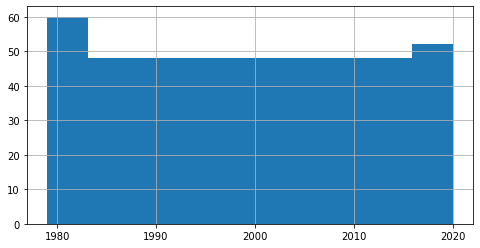

In [8]:
# Distribución de registros por años. Distribución uniforme
precipitacion['date'].str[:4].map(int).hist()

In [9]:
# Distribución de registros por meses (41 años completos y 4 meses extra)
precipitacion['date'].str[5:7].value_counts().sort_index().to_frame().T

01  02  03  04  05  06  07  08  09  10  11  12
date  42  42  42  42  41  41  41  41  41  41  41  41

In [10]:
# Pocos registros son 0
precipitacion.replace(0,np.nan).isnull().mean()

date                                   0.000000
coquimbo                               0.010081
valparaiso                             0.014113
metropolitana_de_santiago              0.006048
libertador_gral__bernardo_o_higgins    0.016129
maule                                  0.002016
biobio                                 0.000000
la_araucania                           0.000000
los_rios                               0.000000
dtype: float64

### Plotting

In [11]:
# Definimos la lista de las ciudades únicamente 
cities = list(precipitacion.select_dtypes(include=['float']))

In [12]:
precipitacion['period'] = precipitacion['date'].map(lambda x: pd.Period(x, 'M'))
precipitacion['year'] = precipitacion['period'].dt.year
precipitacion['month'] = precipitacion['period'].dt.month

In [13]:
# Seteamos el periodo como index ordenado para análisis de series de tiempo
precipitacion = precipitacion.sort_values(['period']).reset_index(drop=True)
precipitacion = precipitacion.set_index('period')

In [14]:
#precipitacion_1 = precipitacion.copy()
# precipitacion = precipitacion_1.copy()

#### Series de Tiempo

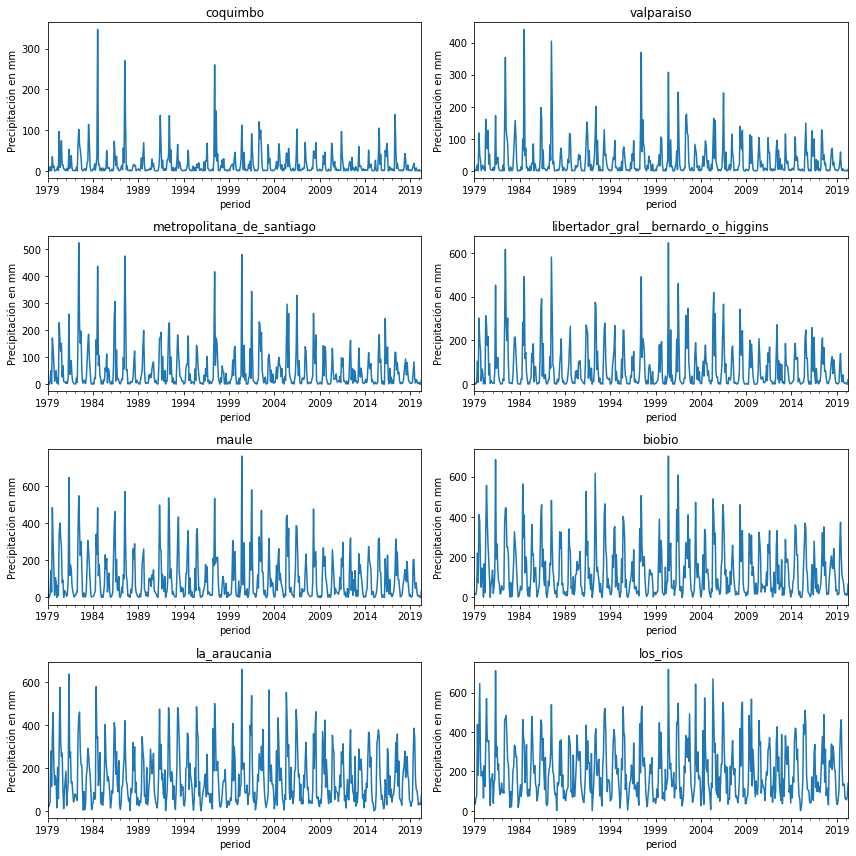

In [15]:
# Evolución de series de tiempo
_, ax = plt.subplots(4,2, figsize=(12,12))
ax = ax.ravel()
for i, city in enumerate(cities):    
    precipitacion[city].plot(ax=ax[i], title=city, ylabel='Precipitación en mm')
    plt.tight_layout();

- Se observan picos y valles a lo largo del tiempo. Esto podría ser estacionalidad. Se evaluará en el mes a mes para validar si la hipótesis es correcta.

#### Análisis de Estacionalidad Mensual

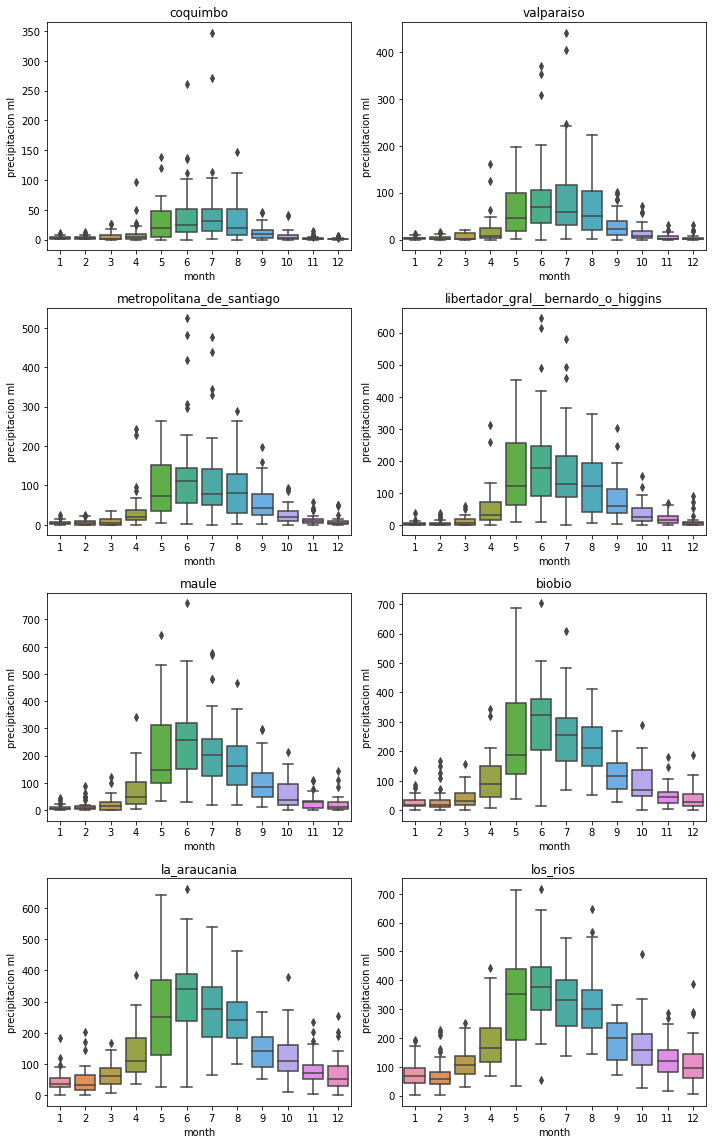

In [16]:
# Plot de la distribución de lluvias de las ciudades por mes
_, ax = plt.subplots(4,2, figsize=(10,16))
ax = ax.ravel()
for i, city in enumerate(cities):    
    sns.boxplot(data=precipitacion, y=city, x='month', ax=ax[i]).set(title=city, ylabel='precipitacion ml')
    plt.tight_layout();

- Con los boxplots se identifica que el año tiene periodos de "lluvia" y periodos de "sequía"
    - La precipitación tiene sus picos entre los meses de mayo (5) y agosto (8)
    - Por otro lado, los periodos de menores lluvias son de noviembre (11) a marzo (3)
- Se observa que los periodos secos de "La Araucania" y "Los Rios" (lugares más lluviosos) tienen niveles de precipitaciones similares a los periodos más lluviosos de "Coquimbo" y "Valparaiso"

## Banco Central

### EDA Inicial

In [17]:
banco_central.sample(5)

periodo imacec_empalmado imacec_produccion_de_bienes  \
406  1991-09-01 00:00:00 UTC              NaN                         NaN   
559  2004-06-01 00:00:00 UTC      664.740.657                 775.846.791   
333  1985-08-01 00:00:00 UTC              NaN                         NaN   
501  1999-08-01 00:00:00 UTC      524.229.498                 647.701.609   
407  1991-10-01 00:00:00 UTC              NaN                         NaN   

    imacec_minero imacec_industria imacec_resto_de_bienes imacec_comercio  \
406           NaN              NaN                    NaN             NaN   
559   992.047.045      786.920.811             58.852.201     479.405.546   
333           NaN              NaN                    NaN             NaN   
501   909.360.951      674.844.928            467.237.743     351.952.689   
407           NaN              NaN                    NaN             NaN   

    imacec_servicios imacec_a_costo_de_factores imacec_no_minero  \
406              NaN                        NaN              NaN   
559      636.193.793                679.584.181      620.452.082   
333              NaN                        NaN              NaN   
501      488.248.624                537.563.473      484.615.138   
407              NaN                        NaN              NaN   

    pib_agropecuario_silvicola pib_pesca pib_mineria pib_mineria_del_cobre  \
406                        NaN       NaN         NaN                   NaN   
559                        NaN       NaN         NaN                   NaN   
333                        NaN       NaN         NaN                   NaN   
501                        NaN       NaN         NaN                   NaN   
407                        NaN       NaN         NaN                   NaN   

    pib_otras_actividades_mineras pib_industria_manufacturera pib_alimentos  \
406                           NaN                         NaN           NaN   
559                           NaN                         NaN           NaN   
333                           NaN                         NaN           NaN   
501                           NaN                         NaN           NaN   
407                           NaN                         NaN           NaN   

    pib_bebidas_y_tabaco pib_textil pib_maderas_y_muebles pib_celulosa  \
406                  NaN        NaN                   NaN          NaN   
559                  NaN        NaN                   NaN          NaN   
333                  NaN        NaN                   NaN          NaN   
501                  NaN        NaN                   NaN          NaN   
407                  NaN        NaN                   NaN          NaN   

    pib_refinacion_de_petroleo pib_quimica  \
406                        NaN         NaN   
559                        NaN         NaN   
333                        NaN         NaN   
501                        NaN         NaN   
407                        NaN         NaN   

    pib_minerales_no_metalicos_y_metalica_basica pib_productos_metalicos  \
406                                          NaN                     NaN   
559                                          NaN                     NaN   
333                                          NaN                     NaN   
501                                          NaN                     NaN   
407                                          NaN                     NaN   

    pib_electricidad pib_construccion pib_comercio pib_restaurantes_y_hoteles  \
406              NaN              NaN          NaN                        NaN   
559              NaN              NaN          NaN                        NaN   
333              NaN              NaN          NaN                        NaN   
501              NaN              NaN          NaN                        NaN   
407              NaN              NaN          NaN                        NaN   

    pib_transporte pib_comunicaciones pib_servicios_financieros  \
406      

In [18]:
bc_describe = eda_describe_df(banco_central)
bc_describe

Shape:	(614, 85)
Memory:	0.39 Mb


100%|██████████| 85/85 [00:00<00:00, 179.95it/s]


feature                                              periodo  \
nunique                                                  612   
total_nulls                                                0   
nulos_perc                                               0.0   
total_notnulls                                           614   
dtype                                                 object   
mode            {'2019-08-01 00:00:00 UTC': '0.32% of rows'}   
mode_freq                                           0.003257   
mean                                                     NaN   
std                                                      NaN   
min                                                      NaN   
max                                                      NaN   
skewness                                                 NaN   
kurtosis                                                 NaN   
top3values                                               NaN   
p05                                                      NaN   
p10                                                      NaN   
p25                                                      NaN   
p50                                                      NaN   
p75                                                      NaN   
p90                                                      NaN   
p95                                                      NaN   

feature        precio_de_la_onza_troy_de_oro_dolaresoz  \
nunique                                            607   
total_nulls                                          1   
nulos_perc                                    0.001629   
total_notnulls                                     613   
dtype                                          float64   
mode                         {412.84: '0.32% of rows'}   
mode_freq                                     0.003257   
mean                                        578.706574   
std                                         468.018646   
min                                              34.94   
max                                            1969.78   
skewness                                      1.118536   
kurtosis                                      0.036318   
top3values                 [1969.78, 1923.35, 1900.36]   
p05                                              63.51   
p10                                            134.364   
p25                                             292.54   
p50                                             385.04   
p75                                              828.8   
p90                                           1325.026   
p95                                           1565.588   

feature        precio_de_la_gasolina_en_eeuu_dolaresm3  \
nunique                                            581   
total_nulls                                         20   
nulos_perc                                    0.032573   
total_notnulls                                     594   
dtype                                           object   
mode                            {nan: '3.25% of rows'}   
mode_freq                                     0.032573   
mean                                               NaN   
std                                                NaN   
min                                                NaN   
max                                                NaN   
skewness                                           NaN   
kurtosis                                           NaN   
top3values                                         NaN   
p05                                                NaN   
p10                                                NaN   
p25                                                NaN   
p50                                                NaN   
p75                                                NaN   
p90                                                NaN   
p95                                                NaN   

feature        precio_de_la_onza_troy

- Hay 2 duplicados en los periodos (614 registros y 612 fechas distintas)
- Una columna tiene el periodo (mes) y las demás curvas son series de tiempo
- No todas las curvas tienen el mismo inicio. Validar año de inicio
- Algunas features tienen todos los registros con datos, pero hay un grupo con el 86% de registros vacíos

### Periodo - Time series key

Se trabajará con pd.Period para trabajar con series de tiempo

In [19]:
banco_central['periodo']

0      2013-03-01 00:00:00 UTC
1      2013-04-01 00:00:00 UTC
2      2013-05-01 00:00:00 UTC
3      2013-06-01 00:00:00 UTC
4      2013-07-01 00:00:00 UTC
                ...           
609    2008-08-01 00:00:00 UTC
610    2008-09-01 00:00:00 UTC
611    2008-10-01 00:00:00 UTC
612    2008-11-01 00:00:00 UTC
613    2008-12-01 00:00:00 UTC
Name: periodo, Length: 614, dtype: object

In [20]:
# Para trabajar con series de tiempo de datos mensuales, solo nos interesa la fecha
banco_central['periodo'] = banco_central['periodo'].str[:10]

In [21]:
# Al evaluar la distribución de meses aparece un mes 13. Borarremos ese dato
banco_central['periodo'].str[5:7].value_counts().sort_index()

01    51
02    51
03    51
04    51
05    51
06    51
07    51
08    53
09    51
10    51
11    51
12    50
13     1
Name: periodo, dtype: int64

In [22]:
# Se encuentran los periodos duplicados
banco_central['periodo'].value_counts()

2019-08-01    2
2018-08-01    2
1992-03-01    1
1991-09-01    1
1991-10-01    1
             ..
1975-03-01    1
1975-04-01    1
1975-05-01    1
1975-06-01    1
2008-12-01    1
Name: periodo, Length: 612, dtype: int64

In [23]:
# Al usar drop_duplicates ya no tenemos duplicados.
# Los datos de esos registros eran exactamente iguales
banco_central.drop_duplicates()['periodo'].value_counts()

2013-03-01    1
1992-04-01    1
1991-09-01    1
1991-10-01    1
1991-11-01    1
             ..
1975-01-01    1
1975-02-01    1
1975-03-01    1
1975-04-01    1
2008-12-01    1
Name: periodo, Length: 612, dtype: int64

In [24]:
banco_central = banco_central.drop_duplicates()

Hallazgos:
- Un registro tiene el mes 13
- Hay 2 registros con datos exactamente iguales

In [25]:
# Eliminaremos el mes 13 y convertiremos el periodo en formato pd.Period
banco_central = banco_central[banco_central['periodo'].str[5:7].map(int)<=12]
banco_central['periodo'] = banco_central['periodo'].map(lambda x: pd.Period(x, 'M'))

In [26]:
banco_central = banco_central.sort_values('periodo').reset_index(drop=True)

__EVALUACION DE TIPO DE DATOS__

In [27]:
# En teoría todos deberían ser floats. Hay demasiados features con tipo de dato object
banco_central.dtypes.value_counts()

object       76
float64       8
period[M]     1
dtype: int64

In [28]:
banco_central.select_dtypes(include=['float'])

precio_de_la_onza_troy_de_oro_dolaresoz  \
0                                      34.94   
1                                      34.99   
2                                      35.09   
3                                      35.62   
4                                      35.95   
..                                       ...   
606                                  1846.37   
607                                  1969.78   
608                                  1923.35   
609                                  1900.36   
610                                  1866.35   

     precio_de_la_onza_troy_de_plata_dolaresoz  \
0                                        1.880   
1                                        1.900   
2                                        1.890   
3                                        1.850   
4                                        1.670   
..                                         ...   
606                                    205.899   
607                                    270.033   
608                                    257.916   
609                                    241.857   
610                                    240.693   

     precio_del_diesel_centavos_de_dolargalon  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   
..                                        ...   
606                                    119.17   
607                                    119.13   
608                                    108.52   
609                                    111.15   
610                                    121.39   

     precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas  \
0                                                  NaN                      
1                                                  NaN                      
2                                                  NaN                      
3                                                  NaN                      
4                                                  NaN                      
..                                                 ...                      
606                                             1.7352                      
607                                             2.3017                      
608                                             1.9186                      
609                                             2.2010                      
610                                             2.6087                      

     precio_del_petroleo_brent_dolaresbarril  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   
..                                       ...   
606                                    42.81   
607                                    44.26   
608                                    41.09   
609                                    40.47   
610                                    43.23   

     precio_del_petroleo_wti_dolaresbarril  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
..                                     ...   
606                                  40.75   
607                                  42.36   
608                                  39.60   
609                                  39.53   
610                                  41.10   

     precio_del_propano_centavos_de_dolargalon_dtn  ventas_autos_nuevos  
0                                              NaN                  NaN  
1                                  

In [29]:
banco_central.select_dtypes(include=['object'])

imacec_empalmado imacec_produccion_de_bienes imacec_minero  \
0                NaN                         NaN           NaN   
1                NaN                         NaN           NaN   
2                NaN                         NaN           NaN   
3                NaN                         NaN           NaN   
4                NaN                         NaN           NaN   
..               ...                         ...           ...   
606      966.693.225                 933.369.433   104.988.256   
607      101.314.552                 926.876.935   103.697.799   
608      103.201.091                 922.072.659   100.589.658   
609      108.402.879                 103.551.978   103.153.982   
610              NaN                         NaN           NaN   

    imacec_industria imacec_resto_de_bienes imacec_comercio imacec_servicios  \
0                NaN                    NaN             NaN              NaN   
1                NaN                    NaN             NaN              NaN   
2                NaN                    NaN             NaN              NaN   
3                NaN                    NaN             NaN              NaN   
4                NaN                    NaN             NaN              NaN   
..               ...                    ...             ...              ...   
606      969.434.205            813.420.488     931.746.336      996.428.565   
607      980.026.279            798.286.232     108.232.893      104.806.496   
608      100.132.069            793.042.271     111.622.999      108.317.886   
609      108.477.999            998.283.785     116.649.655      109.798.567   
610              NaN                    NaN             NaN              NaN   

    imacec_a_costo_de_factores imacec_no_minero pib_agropecuario_silvicola  \
0                          NaN              NaN                        NaN   
1                          NaN              NaN                        NaN   
2                          NaN              NaN                        NaN   
3                          NaN              NaN                        NaN   
4                          NaN              NaN                        NaN   
..                         ...              ...                        ...   
606                966.321.757      955.926.074                188.331.918   
607                100.569.037       10.092.332                 15.867.781   
608                102.561.718      103.388.943                169.746.171   
609                108.112.878      108.891.792                        NaN   
610                        NaN              NaN                        NaN   

       pib_pesca  pib_mineria pib_mineria_del_cobre  \
0            NaN          NaN                   NaN   
1            NaN          NaN                   NaN   
2            NaN          NaN                   NaN   
3            NaN          NaN                   NaN   
4            NaN          NaN                   NaN   
..           ...          ...                   ...   
606  707.214.659    1.324.928           119.520.525   
607  614.712.298  130.864.273           117.055.913   
608  468.872.234  126.941.868           114.236.494   
609          NaN          NaN                   NaN   
610          NaN          NaN                   NaN   

    pib_otras_actividades_mineras pib_industria_manufacturera pib_alimentos  \
0                             NaN                         NaN           NaN   
1                             NaN                         NaN           NaN   
2                             NaN                         NaN           NaN   
3                             NaN                         NaN           NaN   
4                             NaN                         NaN           NaN   
..                            ...                         ...           ...   
606                   130.720.477                 123.810.329   369.570.934   
607                 

Existen puntos en las variables que deberían de ser numéricas, pero el exceso de puntos ensucia el dato.
- Evaluar cuántos puntos "." están en los valores

In [30]:
# A continuación contaremos el número de registros por número de puntos "." que
# hay en los datos por cada feature de tipo object
points_feat = pd.DataFrame()
for feature in list(banco_central.select_dtypes(include=['object'])):
    df_i = banco_central[feature].str.count('\.').value_counts(dropna=False).to_frame().T
    points_feat = points_feat.append(df_i)

In [31]:
# Encontramos que la mayor parte de los datos tienen entre 0 hasta 2 puntos "." en el texto
points_feat

0.0   1.0  2.0    NaN
imacec_empalmado                                 NaN   NaN  298  313.0
imacec_produccion_de_bienes                      NaN   NaN  298  313.0
imacec_minero                                    NaN   NaN  298  313.0
imacec_industria                                 1.0   NaN  298  312.0
imacec_resto_de_bienes                           NaN   NaN  298  313.0
...                                              ...   ...  ...    ...
indice_de_produccion_industrial__manufacturera   NaN   1.0  357  253.0
generacion_de_energia_electrica_cdec_gwh         4.0  20.0  238  349.0
indice_de_ventas_comercio_real_ivcm              NaN   NaN   82  529.0
indice_de_ventas_comercio_real_no_durables_ivcm  NaN   1.0   81  529.0
indice_de_ventas_comercio_real_durables_ivcm     NaN   NaN   82  529.0

[76 rows x 4 columns]

Se buscará contar cuántos puntos hay en los features. Para de esta manera asegurarnos que al eliminar los puntos de manera rápida no estamos destruyendo la integridad de la data.

Si encontramos que solo muy pocos registros tienen 2 puntos, quizá sea mejor no borrar los puntos de esos registros, sino volverlos nulos, y luego buscar imputar un dato coherente. Todo dependerá de qué caso ocurre con más frecuencia.

In [32]:
# Se evalúa cuántos features tienen registros sin puntos
# Solo hay un feature con 178 registros sin puntos. Las demás features no tienen 6 o menos registros sin puntos
points_feat[0.0].value_counts().sort_index().to_frame().T

1.0    3.0    4.0    6.0    178.0
0.0      6      1      4      1      1

In [33]:
# Se evalúa cuántos features tienen registros con un punto
# Solo un feature tiene 342 registros con un punto. Los demás features tienen pocos registros con 1 punto
points_feat[1.0].value_counts().sort_index().to_frame().T

1.0    2.0    3.0    20.0   55.0   82.0   184.0  342.0
1.0     12      1      2      1      1      1      1      1

In [34]:
# La mayor parte de los features tienen registros con 2 puntos --> Entonces podemos proceder a limpiarlos
points_feat[2.0].value_counts().sort_index().to_frame().T

10   81   82   87   90   91   92   93   128  142  238  244  248  249  \
2.0    1    1    3    1    1    2   23   24    1    1    1    1    1    1   

     256  296  297  298  357  369  378  418  
2.0    1    1    1    7    1    1    1    1

In [35]:
points_feat[np.nan].value_counts().sort_index().to_frame().T

19.0   151.0  193.0  241.0  253.0  300.0  312.0  313.0  349.0  360.0  \
NaN      1      1      1      1      1      1      1      8      1      1   

     469.0  483.0  514.0  515.0  517.0  518.0  519.0  529.0  601.0  
NaN      1      1      1      2      2     29     17      4      1

Después de revisar los casos, la mayor parte de los features tienen 2 puntos en sus registros que lo que ocurre con 1 o 0 puntos. --> Podemos proceder a limpiar todos los puntos.

Adicionalmente, se encontró que una variable tenía el caracter 'a' como registro --> Limpiaremos puntos y carácteres alfabéticos. Idealmente deberíamos de tener solo números

In [36]:
#banco_central_1 = banco_central.copy()

In [37]:
#banco_central = banco_central_1.copy()

In [38]:
# Borramemos los caracteres alfabéticos y los puntos, y castearemos todo a float
import re

for feature in list(banco_central.select_dtypes('object')):
    banco_central[feature] = banco_central[feature].apply(lambda x: re.sub('[a-zA-Z.]','',str(x))).replace('',np.nan).map(float)

In [39]:
# Objetivo logrado, ya tenemos solamente variables numéricas
banco_central.dtypes.value_counts()

float64      84
period[M]     1
dtype: int64

In [40]:
# Guardamos las features en una lista
bank_features = list(banco_central.select_dtypes(include=['float']))

In [41]:
banco_central['year'] = banco_central['periodo'].dt.year
banco_central['month'] = banco_central['periodo'].dt.month

In [42]:
banco_central = banco_central.rename(columns={'periodo':'period'})

banco_central = banco_central.set_index('period')
banco_central = banco_central.sort_index()

### Antiguedad de Series

In [43]:
# Ahora, dado que vimos que varias curvas tenían muchos nulos, buscaremos saber desde cuándo se
# tiene su serie de tiempo.

dict_feature = {'feature':[], 'min_year':[], 'mean_year':[], 'max_year':[], 'not_null':[]}
for feature in bank_features:
    dict_feature['feature'].append(feature)
    dict_feature['min_year'].append(banco_central[banco_central[feature].notnull()]['year'].min())
    dict_feature['mean_year'].append(banco_central[banco_central[feature].notnull()]['year'].mean())
    dict_feature['max_year'].append(banco_central[banco_central[feature].notnull()]['year'].max())
    dict_feature['not_null'].append(banco_central[banco_central[feature].notnull()]['year'].count())
    
year_features = pd.DataFrame(dict_feature)
year_features['feature_type'] = year_features['feature'].str.split('_').str[0]
year_features = year_features.sort_values(['feature_type','min_year']).reset_index(drop=True)

In [44]:
year_features.head(10)

feature  min_year    mean_year  max_year  \
0                   derechos_de_importacion      2013  2016.387097      2020   
1  generacion_de_energia_electrica_cdec_gwh      1999  2009.419847      2020   
2                          imacec_empalmado      1996  2007.919463      2020   
3               imacec_produccion_de_bienes      1996  2007.919463      2020   
4                             imacec_minero      1996  2007.919463      2020   
5                          imacec_industria      1996  2007.919463      2020   
6                    imacec_resto_de_bienes      1996  2007.919463      2020   
7                           imacec_comercio      1996  2007.919463      2020   
8                          imacec_servicios      1996  2007.919463      2020   
9                imacec_a_costo_de_factores      1996  2007.919463      2020   

   not_null feature_type  
0        93     derechos  
1       262   generacion  
2       298       imacec  
3       298       imacec  
4       298       imacec  
5       298       imacec  
6       298       imacec  
7       298       imacec  
8       298       imacec  
9       298       imacec

In [45]:
# Todas las features llegan hasta 2020
year_features['max_year'].value_counts()

2020    84
Name: max_year, dtype: int64

In [46]:
# La mayor parte de las features inician en 2013, y se encuentra que algunas features inician
# Hasta en 1970 (inicio del dataset)
year_features['min_year'].value_counts().to_frame().T

2013  1996  2014  2000  1970  2009  1971  1982  2008  2006  1983  \
min_year    51     9     4     3     3     2     1     1     1     1     1   

          2010  1999  2020  1991  1990  1986  1995  
min_year     1     1     1     1     1     1     1

In [47]:
# La tabla generada refleja que la mayor parte de las features son de PIB, de Ocupación, 
# Precios, de Indice Mensual de Act. Economica (imacec) e indices varios
year_features['feature_type'].value_counts().to_frame().T

pib  ocupacion  precio  imacec  indice  tipo  derechos  \
feature_type   28         21      10       9       8     2         1   

              generacion  impuesto  no  ocupados  ventas  
feature_type           1         1   1         1       1

### Plotting 1: ¿Cómo están nuestros datos?

100%|██████████| 84/84 [01:14<00:00,  1.13it/s]


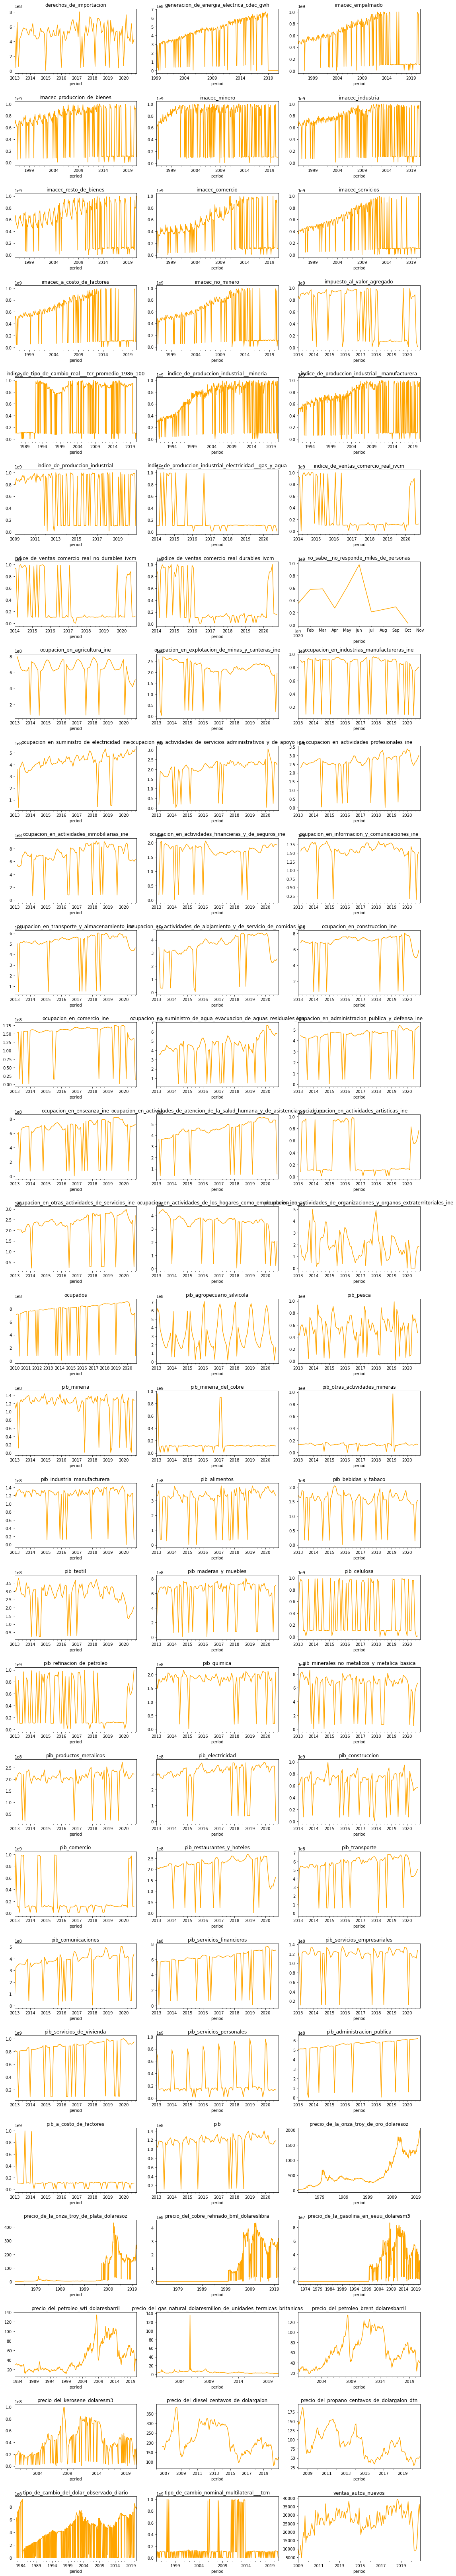

In [48]:
# Plotearemos las curvas desde su primer registro válido para ver si tienen sentido.

_, ax = plt.subplots(28,3, figsize=(15,90))
ax = ax.ravel()
for i, feature in enumerate(tqdm(year_features['feature'])):
    year_min_feature = year_features[year_features['feature']==feature]['min_year'].values[0]
    banco_central[banco_central['year']>=year_min_feature][feature].plot(ax=ax[i], title=feature, color='orange')
    plt.tight_layout();

__Evaluación de curvas__:
- Muchas de las curvas tienen caídas repentinas, esto podría ser debido a alguna estacionalidad
- Sin embargo, no parece haber una periodicidad. Podría tratarse de datos mal cargados.
    - Ejm: generación de energía eléctrica (Se observa una caida fuerte desde 2019)
    - Ejm: imacec. Existen caídas, en la curva imacec_empalmado es relativamente crítico 
    - Después de evaluarlo, al parecer la escala no es la misma en todos los datos.
- En otras curvas también ocurren caídas fuertes y repentinas. Evaluaremos los valores existentes en esas zonas de caída o alza repentina (muy extraña en una serie de tiempo). 

In [49]:
banco_central['ocupacion_en_actividades_artisticas_ine'].tail(20)#.iloc[-40:-1].astype(int)

period
2019-04    122301788.0
2019-05    123712416.0
2019-06    120931548.0
2019-07    129686438.0
2019-08    128238355.0
2019-09    138058637.0
2019-10    136328826.0
2019-11    131441967.0
2019-12    122494327.0
2020-01    129792771.0
2020-02    128940376.0
2020-03    113303687.0
2020-04    828194928.0
2020-05    632411811.0
2020-06    552210606.0
2020-07    551778125.0
2020-08    582058072.0
2020-09    652061811.0
2020-10    769425435.0
2020-11            NaN
Freq: M, Name: ocupacion_en_actividades_artisticas_ine, dtype: float64

In [50]:
# Revisión de generacion_de_energia_electrica_cdec_gwh
banco_central['generacion_de_energia_electrica_cdec_gwh'].tail(30)

# Al parecer el dato no está correctamente cargado, los datos a partir del 2019 no están en la misma escala que antes de ello

period
2018-06    654517025.0
2018-07    668489491.0
2018-08    654060172.0
2018-09    605875493.0
2018-10    635619599.0
2018-11    627997839.0
2018-12    649211128.0
2019-01        65423.0
2019-02        59822.0
2019-03        66258.0
2019-04        61908.0
2019-05        65782.0
2019-06        64481.0
2019-07        67965.0
2019-08         6598.0
2019-09         6107.0
2019-10        62578.0
2019-11         6310.0
2019-12        67864.0
2020-01        67982.0
2020-02        63682.0
2020-03        67645.0
2020-04        61815.0
2020-05        64062.0
2020-06        64191.0
2020-07        64777.0
2020-08         6452.0
2020-09        61631.0
2020-10        64369.0
2020-11            NaN
Freq: M, Name: generacion_de_energia_electrica_cdec_gwh, dtype: float64

In [51]:
banco_central['imacec_empalmado'].iloc[-40:-1].astype(int)

period
2017-08     10673394
2017-09    102858359
2017-10    109336606
2017-11    114580873
2017-12    117716804
2018-01    106798124
2018-02    102427401
2018-03    116434493
2018-04    113216111
2018-05    113849536
2018-06    110639023
2018-07     10572356
2018-08    109690834
2018-09    105009273
2018-10     11348607
2018-11    117910034
2018-12    121411564
2019-01    108704078
2019-02    103529703
2019-03    118124563
2019-04    115341119
2019-05     11628528
2019-06    112156348
2019-07    108969748
2019-08    113886371
2019-09    108450145
2019-10    109677694
2019-11    113216887
2019-12    122347724
2020-01    110288587
2020-02    106982117
2020-03    114025267
2020-04    988542998
2020-05    982393209
2020-06    968929046
2020-07    966693225
2020-08    101314552
2020-09    103201091
2020-10    108402879
Freq: M, Name: imacec_empalmado, dtype: int64

Al revisar diferentes features, las zonas donde ocurren esas caídas en realidad tienen números similares (primeros dígitos), lo que cambia es la escala.

__La escala de los features no es la misma en todos los meses, va del orden de 1:10:100 en algunos casos__ --> __Se debe remediar o corregir la escala__

### Corrección de Escala de Features

__¿Porqué corregir la escala?__

- Los gráficos de series de tiempo que vimos tienen demasiada volatilidad en algunos periodos. Esto podría hasta ser factible con series de tiempo como Acciones o Criptomonedas, pero tener varios picos o valles de pocos puntos no es incluso natural para estos activo.
- Ahora, estamos trabajando con datos como el PBI, indices, tipos de cambio, entre otros. Estos indicadores no deberían ser tan volátiles mensualmente --> Algunos datos están mal
- Hay 2 alternativas: 
    - 1) Eliminar los valores outliers y luego imputar
    - 2) Corregir la escala, aparentemente, los primeros dígitos si podrían estar bien. Mejor limpiar el dato que eliminarlo.


In [52]:
# Aplicaremos la corrección en todos los features numericos
for feature in bank_features:
    get_feature_corrected(data=banco_central, feature=feature, prefix='corrected')

### Plotting 2: ¿Cómo quedan nuestros datos corregidos?

100%|██████████| 84/84 [02:42<00:00,  1.94s/it]


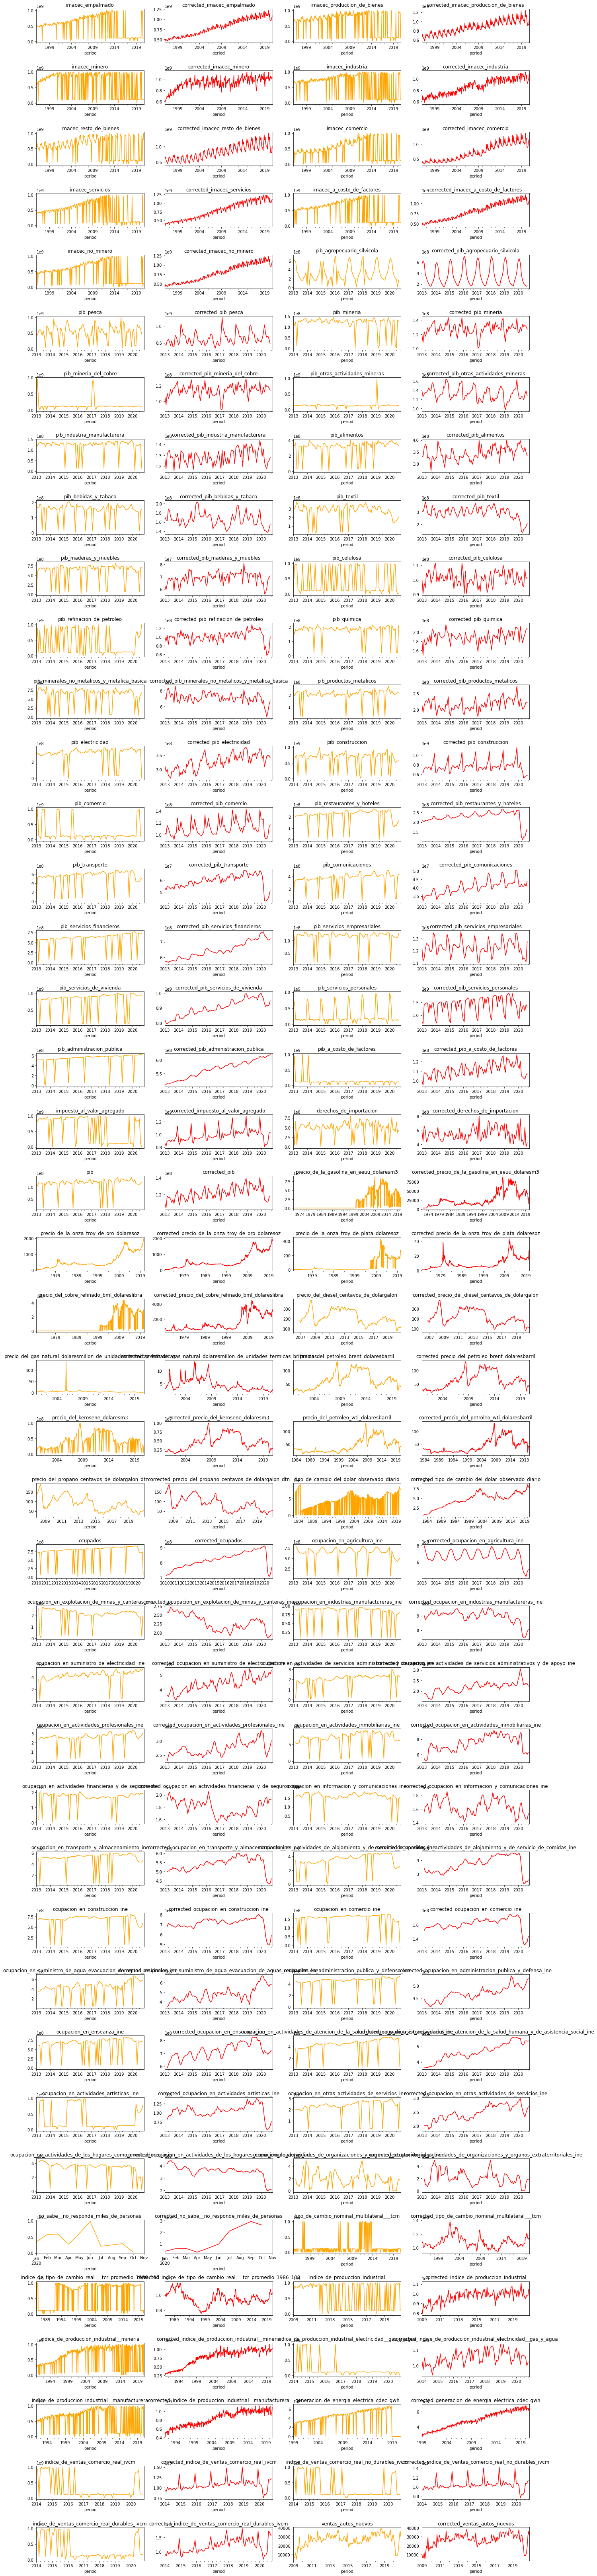

In [53]:
# Después de aplicada la corrección, evalamos qué tan bien quedaron las curvas corregidas
# En Naranja (izquierda): Curva original
# En Rojo (derecha): Curva Corregida

_, ax = plt.subplots(42,4, figsize=(18,90))
ax = ax.ravel()
features = [x for x in banco_central if 'corrected' in x]
for i, feature in enumerate(tqdm(features)):
    original_feature = feature.split('_',1)[-1]
    year_min_feature = year_features[year_features['feature']==original_feature]['min_year'].values[0]
    
    data_feature = banco_central[banco_central['year']>=year_min_feature][[feature, original_feature]]
    
    data_feature[original_feature].plot(ax=ax[2*i], title=original_feature, color='orange')
    data_feature[feature].plot(ax=ax[2*i+1], title=feature, color='red')
    
    plt.tight_layout();

Las curvas corregidas tienen muchisimo más sentido que las curvas originales. 
- Ahora es posible interpretar tendencias, lo que es un input más adecuado.
- Se limpian los valles y cimas repentinas y es más fácil encontrar las estacionalidades (ciclos)
- Aparentemente la mayor parte de las curvas tienen una estacionalidad Anual, pues se observan picos y valles en repetitivos en el año a año. 
- Sin embargo, esto no ocurre en los precios de los comodities con tanta distinción, ni con el tipo de cambio.
- ___Disclaimer:___ 
    - Para corregir los features, se tomó como punto de partida la escala del primer registro. Sin embargo, podría pasar que su escala no sea la correcta.
    - Por el momento estaremos conformes con tener la curva mejor que la original, con más tiempo, se puede evaluar si la escala es la correcta en cada feature

## Precio Leche

In [54]:
precio_leche['mes'] = precio_leche['mes'].map({'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4, 
                                               'May': 5, 'Jun': 6, 'Jul': 7, 'Ago': 8, 
                                               'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dic': 12})

In [55]:
precio_leche['period'] = precio_leche['anio'].map(str)+'-'+precio_leche['mes'].map(str)
precio_leche['period'] = precio_leche['period'].map(lambda x: pd.Period(x))

In [56]:
precio_leche['period'].value_counts()

1979-01    1
2006-09    1
2007-10    1
2007-09    1
2007-08    1
          ..
1992-09    1
1992-08    1
1992-07    1
1992-06    1
2021-02    1
Freq: M, Name: period, Length: 506, dtype: int64

In [57]:
precio_leche = precio_leche.set_index('period')

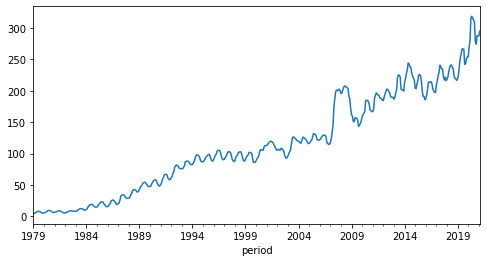

In [58]:
precio_leche['precio_leche'].plot();

In [59]:
precio_leche['precio_leche_trend_12m'] = precio_leche['precio_leche'].rolling(window=12).mean()
precio_leche['precio_leche_estacionalidad'] = precio_leche['precio_leche'] - precio_leche['precio_leche_trend_12m']

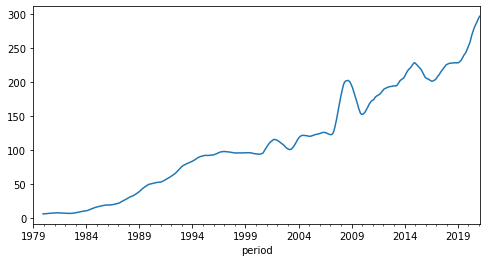

In [60]:
precio_leche['precio_leche_trend_12m'].plot();

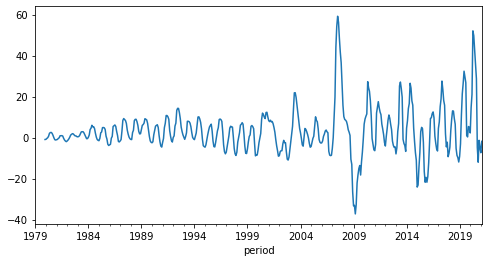

In [61]:
precio_leche['precio_leche_estacionalidad'].plot();

<AxesSubplot:xlabel='mes', ylabel='precio_leche_estacionalidad'>

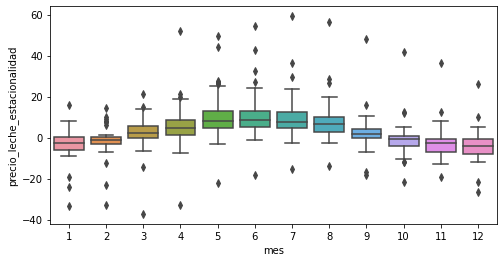

In [62]:
sns.boxplot(data=precio_leche, x='mes', y='precio_leche_estacionalidad')

- El precio de la leche va en aumento, esto se evidencia en la gráfica del trend (media movil de 12 meses). Lo que va de la mano con la tendencia de reducción en la precipitación.
- Una vez que se quita la tendencia de la curva original, nos quedamos con el gráfico estacionario. La estacionalidad es anual.
- Básicamente, el precio de la leche es más alto a mediados de año (cuando llueve mucho), y es más bajo a fines e inicios de año (cuando dejó de llover). Esto tiene sentido con lo comentado líneas arriba, pues el pasto demora en crecer. Ya cuando deje de llover, el pasto será abundante, se alimentará más a las vacas y estas producirán más leche. Esta subida de oferta genera una reducción del precio.

In [63]:
precio_leche

anio  mes  precio_leche  precio_leche_trend_12m  \
period                                                     
1979-01  1979    1          3.85                     NaN   
1979-02  1979    2          4.58                     NaN   
1979-03  1979    3          5.18                     NaN   
1979-04  1979    4          6.06                     NaN   
1979-05  1979    5          7.25                     NaN   
...       ...  ...           ...                     ...   
2020-10  2020   10        274.32              286.345833   
2020-11  2020   11        288.09              289.418333   
2020-12  2020   12        287.29              292.204167   
2021-01  2021    1        287.60              294.995833   
2021-02  2021    2        295.24              297.086667   

         precio_leche_estacionalidad  
period                                
1979-01                          NaN  
1979-02                          NaN  
1979-03                          NaN  
1979-04                          NaN  
1979-05                          NaN  
...                              ...  
2020-10                   -12.025833  
2020-11                    -1.328333  
2020-12                    -4.914167  
2021-01                    -7.395833  
2021-02                    -1.846667  

[506 rows x 5 columns]

# Visualization 

## Data Reloading and Processing

Después de Evaluar las features de cada fuente, procederemos a resumir los procesamientos en el siguiente bloque.

In [64]:
precipitacion = pd.read_csv('./precipitaciones.csv')
banco_central = pd.read_csv('./banco_central.csv')

normalize_table(precipitacion)
normalize_table(banco_central)

In [65]:
# PROCESAMIENTO DE PRECIPITACIÓN

precipitacion['period'] = precipitacion['date'].map(lambda x: pd.Period(x, 'M'))
precipitacion['year'] = precipitacion['period'].dt.year
precipitacion['month'] = precipitacion['period'].dt.month

# Seteamos el periodo como index ordenado para análisis de series de tiempo
precipitacion = precipitacion.sort_values(['period']).reset_index(drop=True)
precipitacion = precipitacion.set_index('period')

In [66]:
# PROCESAMIENTO DE BANCO CENTRAL

# Se eliminan los duplicados
banco_central.rename(columns={'periodo':'period'})
banco_central['periodo'] = banco_central['periodo'].str[:10]
banco_central = banco_central.drop_duplicates()

# Eliminaremos el mes 13 y convertiremos el periodo en formato pd.Period
banco_central = banco_central[banco_central['periodo'].str[5:7].map(int)<=12]
banco_central['periodo'] = banco_central['periodo'].map(lambda x: pd.Period(x, 'M'))

banco_central = banco_central.sort_values('periodo').reset_index(drop=True)


# Borramemos los caracteres alfabéticos y los puntos, y castearemos todo a float
import re

for feature in list(banco_central.select_dtypes('object')):
    banco_central[feature] = banco_central[feature].apply(lambda x: re.sub('[a-zA-Z.]','',str(x))).replace('',np.nan).map(float)
    
# Guardamos las features en una lista
bank_features = list(banco_central.select_dtypes(include=['float']))

banco_central['year'] = banco_central['periodo'].dt.year
banco_central['month'] = banco_central['periodo'].dt.month

banco_central = banco_central.rename(columns={'periodo':'period'})

banco_central = banco_central.set_index('period')
banco_central = banco_central.sort_index()


# Aplicaremos la corrección en todos los features numericos
for feature in bank_features:
    get_feature_corrected(data=banco_central, 
                          feature=feature, 
                          prefix='corrected')

## Función 1

Crea una función que permita graficar series históricas de precipitaciones para un
rango de fechas determinado. Para esto la función debe recibir como argumentos el
nombre de una región, fecha de inicio y fecha de término (asegúrate de verificar en
tu función que tanto el nombre de la región como las fechas ingresadas existan en el
dataset).

In [67]:
# For the following function to work, the dataset has to have the following format already
precipitacion.sample(3)

date   coquimbo  valparaiso  metropolitana_de_santiago  \
period                                                                  
2008-12  2008-12-01   0.573007    0.301948                   0.964564   
1992-11  1992-11-01   8.730595   14.625877                  23.058993   
1988-07  1988-07-01  15.898640   56.963084                  85.356930   

         libertador_gral__bernardo_o_higgins       maule      biobio  \
period                                                                 
2008-12                             0.923907    6.777512   21.596775   
1992-11                            27.400558   30.970250   26.693610   
1988-07                           132.753318  203.911664  245.970957   

         la_araucania    los_rios  year  month  
period                                          
2008-12     26.406420   35.880543  2008     12  
1992-11     52.829566   75.893127  1992     11  
1988-07    187.349216  180.276744  1988      7

In [68]:
# I am adding data as parameter
def plot_precipitation_range(data, city, start_date, end_date):
    """
    Plots the precipitations in a range of dates
    
    Parameters
    ----------
        data (pd.DataFrame): Dataset of precipitations. The index has to be in pd.Period format
        city (str): City queried
        start_date (str): start_date queried. It accepts 'YYYY-MM-DD' and 'YYYY-MM' formats
        end_date (str): end_date queried. It accepts 'YYYY-MM-DD' and 'YYYY-MM' formats
    
    Returns
    -------
        A plot of precipitations in the range of dates
    """
    
    cities = [x.lower() for x in data if x not in ['date','year','month']]
    
    # Normalización de valores
    city_n = city.lower() # To accept upper or lowercase strings
    start_date_n = start_date[:7] # To accept 'yyyy-mm-dd' and 'yyyy-mm' formats
    end_date_n = end_date[:7] # To accept 'yyyy-mm-dd' and 'yyyy-mm' formats
    
    # Validaciones
    assert city_n in cities, f'{city} is not in the database. Please, input a valid city'
    assert start_date_n in data.index, f'{start_date} is not in the database. Please, input a valid start_date'
    assert end_date_n in data.index, f'{end_date} is not in the database. Please, input a valid end_date'
    assert end_date_n > start_date_n, f'start_date cannot be greater than end_date. Please, input valid start_date and end_date values'
    
    # Plot
    serie = data[(data.index>=start_date_n) & (data.index<=end_date_n)][city_n]
    plot = serie.plot(kind='line',
               title=f'Precipitaciones en {city_n.title().replace("_"," ")} desde {start_date} hasta {end_date}',
               ylabel='Precipitación media mensual (mm)',
               xlabel='Periodos',
               figsize=(13,5)
              )
    xticks = [x for x in serie.index if ('-01' in str(x)) or ('-07' in str(x))]
    plot.set_xticks(xticks)
    plot.set_xticklabels(xticks)
    plt.xticks(rotation=90)

Usa esta función para graficar las precipitaciones para la Región Libertador General
Bernardo O'Higgins y para la Región Metropolitana entre las fechas 2000-01-01 y
2020-01-01.

¿Qué observas con respecto a las estacionalidades y tendencias?

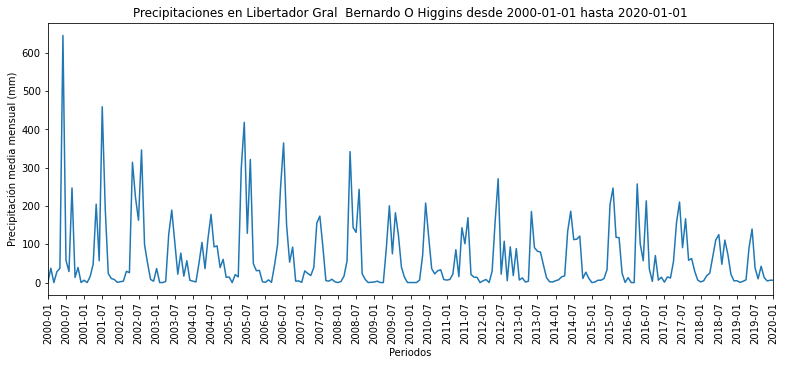

In [69]:
plot_precipitation_range(data=precipitacion, city='libertador_gral__bernardo_o_higgins', start_date='2000-01-01',end_date='2020-01-01')

Se observa una estacionalidad anual en la serie de tiempo. Los valores de precipitación son mínimos a inicios de año y estos se incrementan a mediados de año. Por otro lado, los valores máximos de precipitación decrecen conforme avanzan los años, la tendencia es decreciente. (calentamiento global?)

__¿Cómo afecta esto al precio de la leche?__ 

Si la lluvia es menor, habrán menos campos de cultivo y pastizales con los que alimentar a las vacas. Esta reducción de la oferta, hará más caro el acceso a alimento de vacas, lo que también se traducirá en un costo trasladado al cliente a través de la leche.
- La tendencia del precio de la leche debería ser al alza
- El precio de la leche podría ser también estacionario. Con un precio más elevado cuando haya poco pasto crecido (a mediados de mes, cuando llueve, pues recién comenzará a crecer el pasto), y el precio se reduciría cuando haya pasto en abundancia (cuando el pasto ya esté crecido).

Como se vió algunos bloques de código arriba, el comportamiento es similar para las diferentes ciudades, aunque con una escala diferente.

## Función 2

Crea una función que, para una región, grafique múltiples series de tiempo mensuales de precipitaciones, donde cada serie de tiempo corresponda a un año. La función debe recibir como argumento una lista con los años que queremos graficar (2000, 2005,..) y el nombre de la región. El eje X debe indicar los meses (enero, febrero, etc...).




In [70]:
# For the following function to work, the dataset has to have the following format already
precipitacion.sample(3)

date  coquimbo  valparaiso  metropolitana_de_santiago  \
period                                                                 
2012-01  2012-01-01  4.665542    6.135179                  11.168423   
1998-12  1998-12-01  0.466765    0.727873                   5.149195   
2003-02  2003-02-01  0.535072    0.202159                   0.633641   

         libertador_gral__bernardo_o_higgins      maule     biobio  \
period                                                               
2012-01                             4.687054   5.590691  39.530033   
1998-12                             4.030512  28.217446  25.789222   
2003-02                             0.094341   0.002379   1.568005   

         la_araucania    los_rios  year  month  
period                                          
2012-01     76.719185  148.542623  2012      1  
1998-12     46.056108   62.122855  1998     12  
2003-02     13.905316   43.466305  2003      2

In [71]:
def plot_monthly_precipitation(data, city, year_list):   
    """
    Plots the monthly precipitation in different years
    
    Parameters
    ----------
        data (pd.DataFrame): Dataset of precipitations. The index has to be in pd.Period format
        city (str): City queried
        year_list (list of int): List of years
        
    Returns
    -------
        A plot of monthly precipitations in the years of year_list 
    """
    cities = [x.lower() for x in data if x not in ['date','year','month']]
    
    # Validaciones
    assert city.lower() in cities, f'{city} is not in the database. Please, input a valid city'
    for year in year_list:
        assert int(year) in data.index.year, f'{year} is not in the database. Please, input a valid year in year_list'
    
    # Normalización de valores
    city_n = city.lower() # To accept upper or lowercase strings        
    year_list = [int(x) for x in year_list] # To accept years in string format
    
    # Plot
    data = data[data.year.isin(year_list)][['month','year',city_n]]
    data_monthly = pd.pivot_table(data=data, index='month', columns='year', values=city_n)
    plot = data_monthly.plot(kind='line',
                             title=f'Precipitaciones mensuales en {city_n.title().replace("_"," ")}\nAños: {year_list}',
                             ylabel='Precipitación media mensual (mm)',
                             xlabel='Mes',
                             figsize=(13,7)
                            )
    months = ['Enero', 'Febrero','Marzo','Abril','Mayo','Junio',
              'Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
    xticks = data_monthly.index
    plot.set_xticks(xticks)
    plot.set_xticklabels([months[x-1] for x in xticks]);
    plt.xticks(rotation=90)
    plt.tight_layout();

Usa esta función para graficar las precipitaciones para la Región del Maule durante los años 1982, 1992, 2002, 2012 y 2019.

¿Qué puedes concluir de estos gráficos?

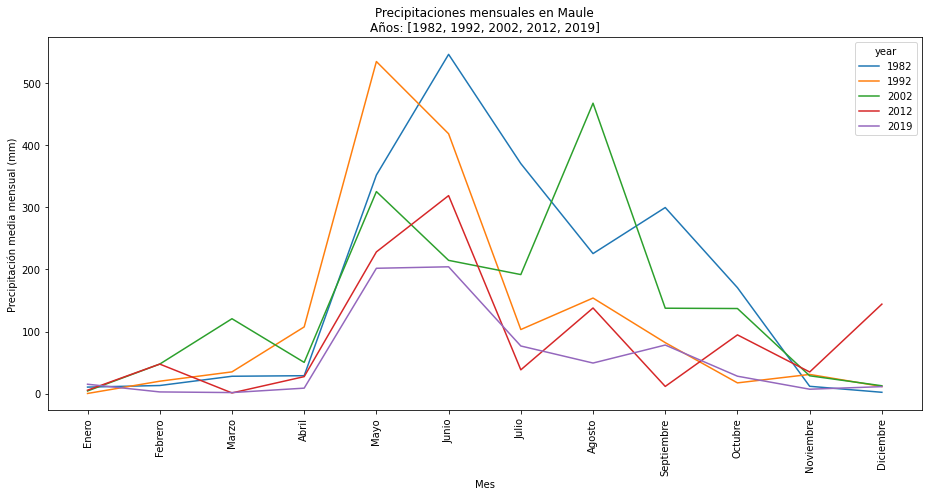

In [72]:
plot_monthly_precipitation(data=precipitacion, 
                           city='Maule', 
                           year_list=[1982, 1992, 2002, 2012, 2019])

En el gráfico mensual se observa que los meses secos son los primeros y últimos meses del año. por otro lado, entre mayo y septiembre, la ciudad de Maule se encuentra en periodo de lluvias.

Esto se replica de manera similar en los gráficos del EDA bloques arriba. Donde se podían ver que los periodos de sequía y los periodos de lluvias en el año se replicaban en cada ciudad.

__¿Cómo afecta esto al precio de la leche?__ 

Como se planteó con el gráfico anterior, el precio de la leche podría ser estacionario tal cual lo es la precipitación. Con un precio más elevado mediados de año (pasto inicia crecimiento), y con un precio más reducido a a inicios y fines de año donde el pasto debería ya estar crecido.

## Función 3

Crea una función que permita visualizar dos series históricas de PIB para un rango de fechas determinado. Para esto la función debe recibir como input el nombre de cada serie, fecha de inicio y fecha de término.

In [73]:
# For the following function to work, the dataset has to have the following format already
banco_central.sample(3)

imacec_empalmado  imacec_produccion_de_bienes  imacec_minero  \
period                                                                  
1991-10               NaN                          NaN            NaN   
2004-04       679726736.0                   81168796.0    935354857.0   
2015-12       114182301.0                  116653604.0    113633912.0   

         imacec_industria  imacec_resto_de_bienes  imacec_comercio  \
period                                                               
1991-10               NaN                     NaN              NaN   
2004-04       814120101.0             670339278.0      528264274.0   
2015-12       105061356.0             129655719.0      127714729.0   

         imacec_servicios  imacec_a_costo_de_factores  imacec_no_minero  \
period                                                                    
1991-10               NaN                         NaN               NaN   
2004-04       633220724.0                 696252053.0       638806872.0   
2015-12       107084027.0                 112863199.0       114248099.0   

         pib_agropecuario_silvicola    pib_pesca  pib_mineria  \
period                                                          
1991-10                         NaN          NaN          NaN   
2004-04                         NaN          NaN          NaN   
2015-12                 391886567.0  413886267.0  143403422.0   

         pib_mineria_del_cobre  pib_otras_actividades_mineras  \
period                                                          
1991-10                    NaN                            NaN   
2004-04                    NaN                            NaN   
2015-12            127470229.0                    160539209.0   

         pib_industria_manufacturera  pib_alimentos  pib_bebidas_y_tabaco  \
period                                                                      
1991-10                          NaN            NaN                   NaN   
2004-04                          NaN            NaN                   NaN   
2015-12                   13417807.0    325455936.0           189212986.0   

          pib_textil  pib_maderas_y_muebles  pib_celulosa  \
period                                                      
1991-10          NaN                    NaN           NaN   
2004-04          NaN                    NaN           NaN   
2015-12  346238489.0            708258387.0   111358257.0   

         pib_refinacion_de_petroleo  pib_quimica  \
period                                             
1991-10                         NaN          NaN   
2004-04                         NaN          NaN   
2015-12                 109799148.0  183215781.0   

         pib_minerales_no_metalicos_y_metalica_basica  \
period                                                  
1991-10                                           NaN   
2004-04                                           NaN   
2015-12                                   764544119.0   

         pib_productos_metalicos  pib_electricidad  pib_construccion  \
period                                                                 
1991-10                      NaN               NaN               NaN   
2004-04                      NaN               NaN               NaN   
2015-12              240910301.0       369343541.0       106566861.0   

         pib_comercio  pib_restaurantes_y_hoteles  pib_transporte  \
period                                                              
1991-10           NaN                         NaN             NaN   
2004-04           NaN                         NaN             NaN   
2015-12   133204507.0                 244769754.0     628692381.0   

         pib_comunicaciones  pib_servicios_financieros  \
period                                                   
1991-10                 NaN                        NaN   
2004-04                 NaN                        NaN   
2015-12         435003536.0                640850969.0   

         pib_servicios_empr

In [74]:
# I am adding data as parameter
def plot_dual_time_serie(data, serie1, serie2, start_date, end_date):
    """
    Plots the precipitations in a range of dates
    
    Parameters
    ----------
        data (pd.DataFrame): Dataset of precipitations. The index has to be in pd.Period format
        city (str): City queried
        start_date (str): start_date queried. It accepts 'YYYY-MM-DD' and 'YYYY-MM' formats
        end_date (str): end_date queried. It accepts 'YYYY-MM-DD' and 'YYYY-MM' formats
    
    Returns
    -------
        A plot of precipitations in the range of dates
    """
    
    bank_series = [x.lower() for x in data if x not in ['year','month']]
    
    # Normalización de valores
    serie1_n = serie1.lower() # To accept upper or lowercase strings
    serie2_n = serie2.lower() # To accept upper or lowercase strings
    start_date_n = start_date[:7] # To accept 'yyyy-mm-dd' and 'yyyy-mm' formats
    end_date_n = end_date[:7] # To accept 'yyyy-mm-dd' and 'yyyy-mm' formats
    
    # Validaciones
    assert serie1_n in bank_series, f'{serie1} is not in the database. Please, input a valid banking serie'
    assert serie2_n in bank_series, f'{serie2} is not in the database. Please, input a valid banking serie'
    assert start_date_n in data.index, f'{start_date} is not in the database. Please, input a valid start_date'
    assert end_date_n in data.index, f'{end_date} is not in the database. Please, input a valid end_date'
    assert end_date_n > start_date_n, f'start_date cannot be greater than end_date. Please, input valid start_date and end_date values'
    
    # Plot
    series_data = data[(data.index>=start_date_n) & (data.index<=end_date_n)][[serie1_n, serie2_n]] / 1e6
    plot = series_data.plot(kind='line',
               title=f'Evolución de curvas de PIB desde {start_date} hasta {end_date}',
               ylabel='Monto de PIB en millones',
               xlabel='Periodos',
               figsize=(13,5)
              )
    xticks = [x for x in series_data.index if ('-01' in str(x)) or ('-07' in str(x))]
    plot.set_xticks(xticks)
    plot.set_xticklabels(xticks)
    plt.xticks(rotation=90)

Grafica las series de tiempo del PIB agropecuario y silvícola y la del PIB de Servicios financieros desde el 2013-01-01 hasta la fecha más reciente en que haya datos.
- ¿Qué puedes decir de cada serie en particular? 
- ¿Hay alguna relación entre estas dos series?

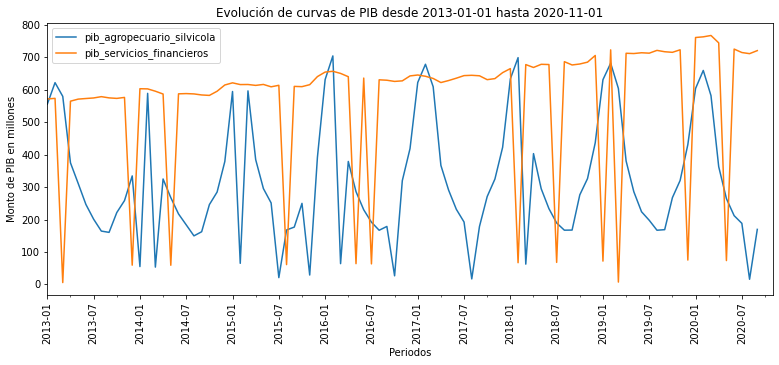

In [75]:
# Plot with original features
plot_dual_time_serie(data=banco_central, 
                     serie1='pib_agropecuario_silvicola', 
                     serie2='pib_servicios_financieros',
                     start_date='2013-01-01',
                     end_date='2020-11-01'
                    )

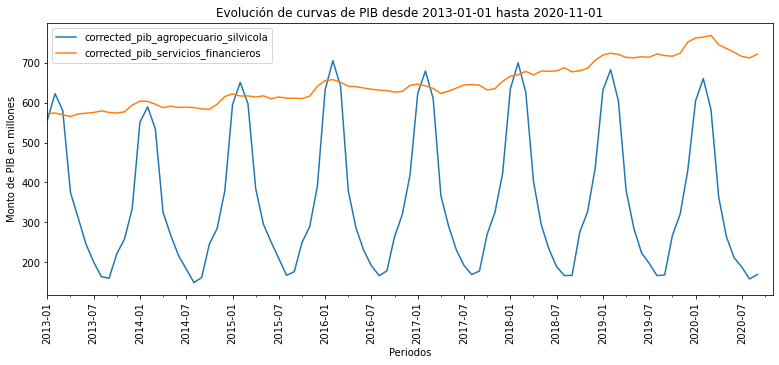

In [76]:
# Plot with features with corrected scale 
plot_dual_time_serie(data=banco_central, 
                     serie1='corrected_pib_agropecuario_silvicola', 
                     serie2='corrected_pib_servicios_financieros',
                     start_date='2013-01-01',
                     end_date='2020-11-01'
                    )

Las conclusiones de la revisión de ambas curvas puede ser interpretada desde ambos gráficos, sin embargo, es mucho más evidente en el gráfico de features corregidas por escala.

- El PIB de Servicios Financieros tiene una tendencia al alza. Al parecer hay cierta estacionalidad que tiene los picos a inicios del año (probablemente por gastos navideños, de año nuevo y vacaciones). Sin embargo, la variación es muy leve en el mes a mes.
- Por otro lado el PIB del sector Agropecuario y Silvicola tiene una estacionalidad muy fuerte. Los picos de PIB se dan a inicios de año, y los valles a mediados de año. Con ello, sus picos coinciden con periodos con precipitaciones bajas.
- Por lo visto, el PIB de cada sector puede tener un comportamiento distinto, por la misma naturaleza del negocio. El sector financiero es más estable en el tiempo (las personas siempre compran), mientras que el sector agrario está dependiente de los tiempos de lluvia y sequía.

__¿Cómo impacta esto en el precio de la leche?__
- El PIB agrario es una respuesta a la producción de la leche y su precio de venta. Justo observamos que el PIB es bajo cuando llueve mucho. La lógica detras de esto es que el pasto demora en crecer. De manera que si llueve en junio, el pasto crecerá y alimentará a las vacas meses después. Con esto, la producción de la leche llegaría al tope máximo para cuando ya haya dejado de llover y haya pasto en abundancia.
- Por otro lado, un PIB alto no implica leche cara. En esas temporadas es posible que haya mucha leche en el mercado, y por tanto, su precio unitario sea bajo. Por otro lado, en tiempos de lluvia, más bien los precios podrían ser más altos, porque habría escasez de leche en ese momento (el pasto recién comenzará a crecer), por lo que el P x Q (price x quantity) final deriva en un PIB bajo.

# Tratamiento y Creación de Variables: Precio Leche

In [77]:
precio_leche = pd.read_csv('./precio_leche.csv')
normalize_table(precio_leche)

In [78]:
# PROCESAMIENTO DE PRECIO DE LECHE
precio_leche['mes'] = precio_leche['mes'].map({'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4, 
                                               'May': 5, 'Jun': 6, 'Jul': 7, 'Ago': 8, 
                                               'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dic': 12})

precio_leche['period'] = precio_leche['anio'].map(str)+'-'+precio_leche['mes'].map(str)
precio_leche['period'] = precio_leche['period'].map(lambda x: pd.Period(x))
precio_leche = precio_leche.set_index('period')

precio_leche['precio_leche_trend_12m'] = precio_leche['precio_leche'].rolling(window=12).mean()
precio_leche['precio_leche_estacionalidad'] = precio_leche['precio_leche'] - precio_leche['precio_leche_trend_12m']

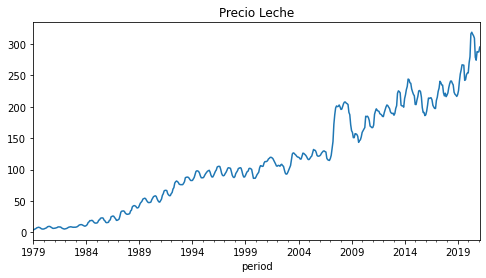

In [79]:
precio_leche['precio_leche'].plot(title='Precio Leche');

Como se observó en el análisis de Banco Central, la mayor parte de la curvas son del 2013, y hay 4 curvas adicionales en el 2014. Tomaremos la información desde el 2014 para poder considerar todas las curvas posibles. Ignoraremos la columna "no_sabe_no_responde" pues solo tiene información desde el 2020.

- Con la información desde el 2014 tendremos poco más de 6 años de historia

In [80]:
pprint

Pretty printing has been turned OFF


In [81]:
cities = list(precipitacion.select_dtypes(include=['float']))
cities

['coquimbo', 'valparaiso', 'metropolitana_de_santiago', 'libertador_gral__bernardo_o_higgins', 'maule', 'biobio', 'la_araucania', 'los_rios']

In [82]:
# Tomaremos solamente las curvas corregidas
bank_corrected_features = [x for x in list(banco_central) if 'corrected' in x and 'no_sabe' not in x]
bank_corrected_features

['corrected_imacec_empalmado', 'corrected_imacec_produccion_de_bienes', 'corrected_imacec_minero', 'corrected_imacec_industria', 'corrected_imacec_resto_de_bienes', 'corrected_imacec_comercio', 'corrected_imacec_servicios', 'corrected_imacec_a_costo_de_factores', 'corrected_imacec_no_minero', 'corrected_pib_agropecuario_silvicola', 'corrected_pib_pesca', 'corrected_pib_mineria', 'corrected_pib_mineria_del_cobre', 'corrected_pib_otras_actividades_mineras', 'corrected_pib_industria_manufacturera', 'corrected_pib_alimentos', 'corrected_pib_bebidas_y_tabaco', 'corrected_pib_textil', 'corrected_pib_maderas_y_muebles', 'corrected_pib_celulosa', 'corrected_pib_refinacion_de_petroleo', 'corrected_pib_quimica', 'corrected_pib_minerales_no_metalicos_y_metalica_basica', 'corrected_pib_productos_metalicos', 'corrected_pib_electricidad', 'corrected_pib_construccion', 'corrected_pib_comercio', 'corrected_pib_restaurantes_y_hoteles', 'corrected_pib_transporte', 'corrected_pib_comunicaciones', 'correc

## Dataset Definition

In [90]:
# Creación del dataset. Se toma desde el 2013 para poder considerar la historia completa de la mayoría de las curvas 
# (salvo unas cuantas que inician en 2014). 
# Pensamos utilizar un modelo basado en árboles más adelante. Para esto nos conviene tener más datos.

data = precio_leche[precio_leche.index.year>=2013][['precio_leche']]\
                .join(precipitacion[cities])\
                .join(banco_central[bank_corrected_features])                

In [92]:
data_1 = data.copy()

In [93]:
# Se define como target objetivo el precio de leche siguiente (desfase de un mes)
data['target'] = data['precio_leche'].shift(-1)

In [94]:
data

precio_leche   coquimbo  valparaiso  metropolitana_de_santiago  \
period                                                                    
2013-01        186.63  10.155732    9.476023                   9.722886   
2013-02        189.52   2.662333    3.329740                  10.572315   
2013-03        197.60   0.282052    2.228588                   3.500923   
2013-04        201.70   0.142111    1.629529                   6.723540   
2013-05        221.60  59.775399  114.732581                 134.130436   
...               ...        ...         ...                        ...   
2020-10        274.32        NaN         NaN                        NaN   
2020-11        288.09        NaN         NaN                        NaN   
2020-12        287.29        NaN         NaN                        NaN   
2021-01        287.60        NaN         NaN                        NaN   
2021-02        295.24        NaN         NaN                        NaN   

         libertador_gral__bernardo_o_higgins       maule      biobio  \
period                                                                 
2013-01                             6.645054    7.531215   10.610359   
2013-02                            12.139349   39.104867   49.439734   
2013-03                             1.394124    4.366248   11.977028   
2013-04                             3.577488   10.806847   42.941649   
2013-05                           185.615613  234.374501  288.971343   
...                                      ...         ...         ...   
2020-10                                  NaN         NaN         NaN   
2020-11                                  NaN         NaN         NaN   
2020-12                                  NaN         NaN         NaN   
2021-01                                  NaN         NaN         NaN   
2021-02                                  NaN         NaN         NaN   

         la_araucania    los_rios  corrected_imacec_empalmado  \
period                                                          
2013-01     21.286717   36.419186                9.553908e+08   
2013-02     84.571386  161.760892                9.053597e+08   
2013-03     36.493313   73.323954                1.027962e+09   
2013-04     95.051980  176.105375                1.016648e+09   
2013-05    289.062544  380.996731                1.016430e+09   
...               ...         ...                         ...   
2020-10           NaN         NaN                1.084029e+09   
2020-11           NaN         NaN                         NaN   
2020-12           NaN         NaN                         NaN   
2021-01           NaN         NaN                         NaN   
2021-02           NaN         NaN                         NaN   

         corrected_imacec_produccion_de_bienes  corrected_imacec_minero  \
period                                                                    
2013-01                           1.009724e+09             9.517826e+08   
2013-02                           9.653279e+08             8.571518e+08   
2013-03                           1.054682e+09             9.785544e+08   
2013-04                           9.992728e+08             9.273333e+08   
2013-05                           9.939599e+08             9.613316e+08   
...                                        ...                      ...   
2020-10                           1.035520e+09             1.031540e+09   
2020-11                                    NaN                      NaN   
2020-12                                    NaN                      NaN   
2021-01                                    NaN                      NaN   
2021-02                                    NaN                      NaN   

         corrected_imacec_industria  corrected_imacec_resto_de_bienes  \
period                                                                  
2013-01                9.961830e+08                      1.072796e+09   
2013-02                9.194709e+08                    

In [95]:
data.isnull().sum().sort_values()

precio_leche                                                           0
target                                                                 1
corrected_tipo_de_cambio_del_dolar_observado_diario                    3
corrected_ventas_autos_nuevos                                          3
corrected_precio_de_la_gasolina_en_eeuu_dolaresm3                      3
                                                                      ..
valparaiso                                                            10
corrected_indice_de_produccion_industrial_electricidad__gas_y_agua    16
corrected_indice_de_ventas_comercio_real_ivcm                         16
corrected_indice_de_ventas_comercio_real_no_durables_ivcm             16
corrected_indice_de_ventas_comercio_real_durables_ivcm                16
Length: 93, dtype: int64

In [96]:
data.isnull().sum().sort_values().value_counts()

5     30
6     21
4     15
3     13
10     8
16     4
0      1
1      1
dtype: int64

Se observa que prácticamente ninguna de las series llega a estar tan actualizada como la serie del precio de la leche. Las series que serán usadas como features tienen vacíos entre los 3 y 10 registros más recientes. Unas 4 variables, además no empiezan en 2014, sino 2013 (12 nulos adicionales --> 16).

- Si entrenamos el modelo para variables rezagadas cercanas, también tendremos que tener esas variables al momento de la predicción.
- Necesitamos llenar los datos de esas series que tienen vacíos, sino pasaríamos a predecir con datos nulos como input.

### Imputación de valores en series

En el análisis de la tabla de Banco Central y la data de precipitaciones, se noto estacionariedad y tendencias en la mayor parte de las curvas (salvo en precios de commodities, tipo de cambio, entre otros). 

Se puede usar eso como un simil para la imputación de nuevos datos, considerando un ajuste con respecto al dato del año pasado.

Se hará una regla de 3 simple para la imputación de datos.

In [97]:
# IMPUTACIÓN DE VALORES EN REGISTROS RECIENTES

# Por cada feature en el dataset, se utilizará una regla de 3 simple que considere los últimos 
# 3 años para imputar los valores vacíos. De esa manera se busca respetar la estacionalidad y
# también añadir un factor suavizado de la tendencia (por eso se tomarán 3 años)

for feature in [x for x in data if 'target' not in x]:
    serie = data[feature]
    empty_registries = data[serie.isnull()][feature].index

    for index in empty_registries:
        
        try: 
            past_01 = serie[index-1]
            past_13 = serie[index-13]
            past_25 = serie[index-25]
            past_37 = serie[index-37]

            past_12 = serie[index-12]
            past_24 = serie[index-24]
            past_36 = serie[index-36]

            # Se define un nuevo valor para llenar el vacío, como una regla de 3 simple entre el dato
            # anterior y la relación de datos de los 3 años pasados.
            imputed_value = past_01 / (past_13 + past_25 + past_37) * (past_12 + past_24 + past_36)

            serie.loc[serie.index==index] = imputed_value
        except:
            pass

<AxesSubplot:xlabel='period'>

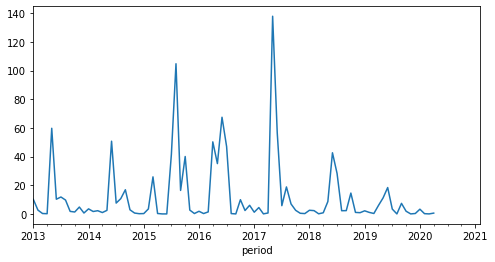

In [98]:
# Antes
data_1['coquimbo'].plot()

<AxesSubplot:xlabel='period'>

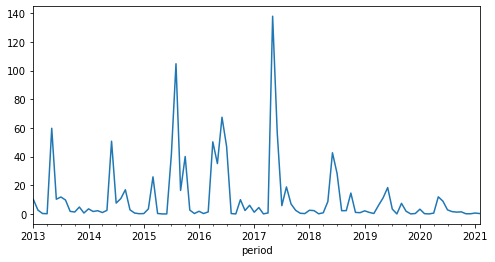

In [99]:
# Después
data['coquimbo'].plot()

<AxesSubplot:xlabel='period'>

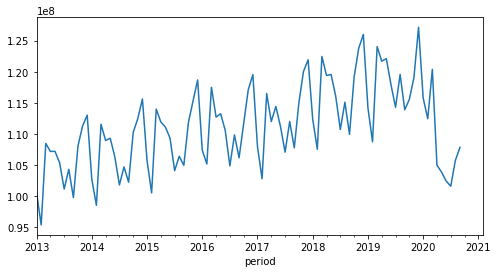

In [100]:
# Antes
data_1['corrected_pib_a_costo_de_factores'].plot()

<AxesSubplot:xlabel='period'>

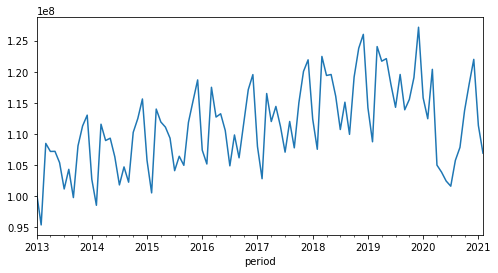

In [101]:
# Después
data['corrected_pib_a_costo_de_factores'].plot()

In [102]:
data

precio_leche   coquimbo  valparaiso  metropolitana_de_santiago  \
period                                                                    
2013-01        186.63  10.155732    9.476023                   9.722886   
2013-02        189.52   2.662333    3.329740                  10.572315   
2013-03        197.60   0.282052    2.228588                   3.500923   
2013-04        201.70   0.142111    1.629529                   6.723540   
2013-05        221.60  59.775399  114.732581                 134.130436   
...               ...        ...         ...                        ...   
2020-10        274.32   1.431078   10.423888                  26.014797   
2020-11        288.09   0.113608    1.561028                   6.933749   
2020-12        287.29   0.104768    1.073591                   4.094614   
2021-01        287.60   0.605592    1.600288                   4.404444   
2021-02        295.24   0.266743    0.260632                   1.305617   

         libertador_gral__bernardo_o_higgins       maule      biobio  \
period                                                                 
2013-01                             6.645054    7.531215   10.610359   
2013-02                            12.139349   39.104867   49.439734   
2013-03                             1.394124    4.366248   11.977028   
2013-04                             3.577488   10.806847   42.941649   
2013-05                           185.615613  234.374501  288.971343   
...                                      ...         ...         ...   
2020-10                            34.188784   54.164490  113.362672   
2020-11                            12.896092   27.561849   57.064039   
2020-12                             4.033372    5.185911   18.056679   
2021-01                             2.873104    7.189189   24.016012   
2021-02                             1.223759    3.553894   11.376850   

         la_araucania    los_rios  corrected_imacec_empalmado  \
period                                                          
2013-01     21.286717   36.419186                9.553908e+08   
2013-02     84.571386  161.760892                9.053597e+08   
2013-03     36.493313   73.323954                1.027962e+09   
2013-04     95.051980  176.105375                1.016648e+09   
2013-05    289.062544  380.996731                1.016430e+09   
...               ...         ...                         ...   
2020-10    105.614372  173.565215                1.084029e+09   
2020-11     58.387882  106.453915                1.127088e+09   
2020-12     28.584419   69.429977                1.178496e+09   
2021-01     25.769306   46.545074                1.062154e+09   
2021-02     16.306850   30.801648                1.020255e+09   

         corrected_imacec_produccion_de_bienes  corrected_imacec_minero  \
period                                                                    
2013-01                           1.009724e+09             9.517826e+08   
2013-02                           9.653279e+08             8.571518e+08   
2013-03                           1.054682e+09             9.785544e+08   
2013-04                           9.992728e+08             9.273333e+08   
2013-05                           9.939599e+08             9.613316e+08   
...                                        ...                      ...   
2020-10                           1.035520e+09             1.031540e+09   
2020-11                           1.084338e+09             1.052721e+09   
2020-12                           1.194016e+09             1.117331e+09   
2021-01                           1.079818e+09             9.639012e+08   
2021-02                           1.052163e+09             9.308379e+08   

         corrected_imacec_industria  corrected_imacec_resto_de_bienes  \
period                                                                  
2013-01                9.961830e+08                      1.072796e+09   
2013-02                9.194709e+08                    

Con el ejercicio de imputación anterior, ya contamos con datos disponibles en los meses más recientes para realizar una predicción después de entrenar.

___Disclaimer:___ 
- Resolvimos esta imputación de manera sencilla, pero si se buscara ser más exactos, se tendría que analizar cada feature y evaluar si el método es válido según la naturaleza de cada tipo de dato.
- Realizar la imputación ya agrega un ruido al problema, pues no estamos realmente seguros de los valores de los datos. Lo que nos llevará a realizar la estimación con valores estimados (con lo que los errores podrían sumarse)
- Otra alternativa podría ser trabajar únicamente con variables rezagadas 10 meses para atrás (para únicamente considerar valores reales), por ejemplo. Sin embargo, la precisión podría reducirse al tener un gap temporal elevado.


En esta ocasión procedemos a trabajar con los valores imputados en los registros más recientes. En un siguiente experimento podría probarse entrenando solo con variables rezagadas por 10 meses a más.

## Correlation Analysis


¿Cómo podríamos evaluar la correlación entre las distintas series de tiempo y cómo
se tienen que correlacionar para entrenar un modelo? ¿Mucha correlación, no
correlacionadas, da igual?

Analizaremos la correlación entre las variables. Utilizaremos como método Pearson, pues es un estandar recomendado para análisis de Time Series.

__EVALUACIÓN__
- Idealmente lo mejor es trabajar con variables con alta correlación (positiva o negativa). La correlación de Pearson implica si una variable está relacionada con otra directa (positivo) o inversamente (negativo). LA CORRELACIÓN NO IMPLICA CAUSALIDAD.
- Cuando la correlación es muy baja, en cambio, es poco probable que el movimiento de una afecte a la otra.
- Aparentemente las variables que pueden estár más correlacionadas con la variable adelantada 1 periodo (target) tienen entre si:
    - precio de leche, de onza de oro, ocupación de industrias manufactureras, de actividades del hogar, pib servicios financieros,  de restaurantes, alimentos entre otros.

___NOTAS A CONSIDERAR:___
- Sin embargo, si bien el análisis refleja algunas cosas con sentido, se tiene que tener en cuenta lo siguiente:
    - Este es un análisis de correlación con un mes de desfase (no vemos todo el panorama)
    - Dado que varias variables son estacionarias y tienen una tendencia en el tiempo, podríamos buscar evaluar medias móviles o desfases de más meses (3, 6, 12 meses desde el target, por ejemplo).
    - Como hipótesis, podría pasar que una variable desfasada 1 mes tenga correlación baja, sin embargo, esta correlación podría subir si el desfase fuera de 1 año, por ejemplo. Esto debido a la estacionariedad existente en varias de estas series de tiempo.
- Dado que tenemos muy pocos datos (registros), no podemos considerar demasiadas variables, por lo que haremos un corte de las variables que se considerarán. Con esto, tomaremos las features con un coeficiente de correlación > 0.40 y consideraremos también las columnas de precipitaciones en ciudades. Estas últimas no salieron con mucha correlación, pero tal vez su curva desfasada funcione mejor.


    
- Idealmente, tendríamos que limpiar las variables (distintas al target) que tienen alta correlación entre si (ej: "feature2" podría ser una transformación lineal de "feature1"), pues podrían dar información muy similar, que realmente no aporta al modelo. Sin embargo, como estamos tratando con series de tiempo, la ocurrencia de estas correlaciones no necesariamente implican lo mismo. En esta ocasión no se realizará la limpieza de features correlacionados. Podría ser parte de una siguiente iteración.


In [103]:
corr_target = data.corr(method='pearson')['target'].abs().sort_values(ascending=False)
corr_target[corr_target>=0.4]

target                                                                                          1.000000
precio_leche                                                                                    0.958994
corrected_ocupacion_en_industrias_manufactureras_ine                                            0.737909
corrected_pib_servicios_financieros                                                             0.733403
corrected_precio_de_la_onza_troy_de_oro_dolaresoz                                               0.729964
corrected_ocupacion_en_actividades_de_los_hogares_como_empleadores_ine                          0.713194
corrected_ocupacion_en_suministro_de_agua_evacuacion_de_aguas_residuales_ine                    0.652834
corrected_pib_textil                                                                            0.640388
corrected_pib_administracion_publica                                                            0.640135
corrected_ocupacion_en_actividades_de_atencion_de_la_sa

In [104]:
corr_target[corr_target.index.isin(cities)]

coquimbo                               0.124650
biobio                                 0.102470
los_rios                               0.073002
metropolitana_de_santiago              0.071042
libertador_gral__bernardo_o_higgins    0.047470
valparaiso                             0.043907
la_araucania                           0.028202
maule                                  0.004656
Name: target, dtype: float64

In [105]:
features_to_eval = list(corr_target[corr_target>=0.4].index) + list(corr_target[corr_target.index.isin(cities)].index)

Nos interesa saber qué features tienen una mayor correlación (valor absoluto)


## Creación de Variables

Crea las variables:
- A partir de la variable fecha, crea nuevas variables para el año, mes, trimestre.
- Lags y estadísticas acumuladas (por ejemplo: promedio, varianza) de las variables que consideres relevantes.

In [106]:
print(eda_get_memory(data))
data.shape

0.07 Mb


(98, 93)

El dataset es bastante pequeño en tamaño. Se crearán variables desfasadas y rolling means y std de las variables seleccionada previamente

In [107]:
data_2 = data[features_to_eval].copy()

In [108]:
data_2.shape

(98, 32)

In [109]:
# CREACIÓN DE VARIABLES - Se crearán las variables para todas las features

# Como el target es un dato desfasado 1 hacia el futuro, el dato original del registro
for feature in [x for x in data_2 if 'target' not in x]:
    
    # Se realizarán desfases temporales y medias móviles: ARIMA-like
    
    # Desfases temporales al target - 3, 6, 12 meses, # No usaremos más años, porque generaríamos nulos
    for i in [2, 5, 11]:
        data_2[f'{feature}_{i}'] = data_2[f'{feature}'].shift(i)

    # Medias móviles y std móviles - 3, 6, 12 meses # No usaremos más años, porque generaríamos nulos        
    for i in [3, 6, 12]:
        data_2[f'{feature}_mean{i}'] = data_2[f'{feature}'].rolling(i).mean()
        data_2[f'{feature}_std{i}'] = data_2[f'{feature}'].rolling(i).std()

In [110]:
print(eda_get_memory(data_2))
data_2.shape

0.23 Mb


(98, 311)

In [111]:
correlation2 = abs(data_2.corr(method='pearson')['target']).sort_values(ascending=False)
correlation2.head(20)

target                                                                                 1.000000
precio_leche                                                                           0.958994
precio_leche_mean3                                                                     0.900701
precio_leche_mean12                                                                    0.844563
precio_leche_mean6                                                                     0.823711
corrected_precio_de_la_onza_troy_de_oro_dolaresoz_mean12                               0.801752
corrected_pib_alimentos_mean6                                                          0.797788
precio_leche_2                                                                         0.795941
corrected_pib_servicios_financieros_mean6                                              0.784039
corrected_ocupacion_en_suministro_de_agua_evacuacion_de_aguas_residuales_ine_mean6     0.779456
corrected_pib_servicios_financieros_2   

__Analisis de nuevas variables creadas__

Tras realizar el enriquecimiento de variables, se observa que las medias móviles y las variables traslapadas muestran una alta correlación.

___Disclaimer___
- Hemos podido generar varias decenas de features, sin embargo, un modelo basado en árboles suele requerir una gran cantidad de registros. Por esa razón, será conveniente crear distintos algoritmos para evaluar cual funciona mejor.

# Modelamiento

Entrena un modelo que permita predecir el precio de la leche el próximo mes, en
función de los datos entregados.
- Si necesitas crear variables adicionales que pueden aportar información al
modelo, tienes total libertad.

Construye una base de test (o de cross validation). ¿Cuál fue tu definición de
tiempo/cantidad de datos para este set de datos? Explica por qué la elegiste así.

## Modelling Strategy

Buscamos predecir el mes siguiente. Entonces --> El valor a predecir usará los datos del último registro como features.

In [112]:
dset_trn_tst = data_2.iloc[:-1,:]
dset_predict = data_2.iloc[-1:,:]

La estrategia será probar distintos modelos sobre una combinación de features. 
- 1ro probaremos la variable precio_leche (auto regresiva)
- Posteriormente probaremos más features en el orden de mayor o menor correlación que se encontró

In [113]:
features_to_eval

['target', 'precio_leche', 'corrected_ocupacion_en_industrias_manufactureras_ine', 'corrected_pib_servicios_financieros', 'corrected_precio_de_la_onza_troy_de_oro_dolaresoz', 'corrected_ocupacion_en_actividades_de_los_hogares_como_empleadores_ine', 'corrected_ocupacion_en_suministro_de_agua_evacuacion_de_aguas_residuales_ine', 'corrected_pib_textil', 'corrected_pib_administracion_publica', 'corrected_ocupacion_en_actividades_de_atencion_de_la_salud_humana_y_de_asistencia_social_ine', 'corrected_ocupacion_en_administracion_publica_y_defensa_ine', 'corrected_tipo_de_cambio_del_dolar_observado_diario', 'corrected_pib_restaurantes_y_hoteles', 'corrected_pib_alimentos', 'corrected_ocupacion_en_suministro_de_electricidad_ine', 'corrected_ocupacion_en_actividades_de_servicios_administrativos_y_de_apoyo_ine', 'corrected_indice_de_tipo_de_cambio_real___tcr_promedio_1986_100', 'corrected_generacion_de_energia_electrica_cdec_gwh', 'corrected_pib_servicios_de_vivienda', 'corrected_ocupacion_en_otr

## Modelamiento

In [114]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor
from lightgbm import LGBMRegressor

In [115]:
def test_model(algorithm, X_train, y_train, X_test, y_test):
    '''This function allows the testing of different algorithms'''
    model = algorithm
    model.fit(X_train, y_train)
    
    # Evaluation
    train_rmse = mean_squared_error(y_train, model.predict(X_train)) ** 0.5
    test_rmse = mean_squared_error(y_test, model.predict(X_test)) ** 0.5
    print(f'Train RMSE: {train_rmse:.3f}\tTest RMSE: {test_rmse:.3f}\tModel: \t{model.__str__()}')
    return model

In [116]:
def test_features_with_models(data, features, print_features=True):
    '''This function allows the testing of features and algorithms'''
    
    X = data[data.index.year>=2014][features]
    y = data[data.index.year>=2014]['target']
    
    # Se considerarán solo los features que no tengan nulos para poder usar distintos modelos
    serie_not_null = X.isnull().sum()
    features = list(serie_not_null[serie_not_null==0].index)
    X = X[features]
    
    # Train y Test Definition --> Como es una serie de tiempo, se usará data pasada (train) para predecir data futura (test)
    # Se utiliza la información desde 2014, para de esa manera utilizar la mayor cantidad posible para train
    
    X_train = X[(X.index.year>=2014) & (X.index.year<=2019)]
    y_train = y[(y.index.year>=2014) & (y.index.year<=2019)]

    X_test = X[(X.index.year>=2020) & (X.index.year<=2021)]
    y_test = y[(y.index.year>=2020) & (y.index.year<=2021)]
    
    if print_features:
        print(f'Features: {features}\n')
    
    for algo in [Ridge(), 
                Lasso(), 
                LinearRegression(), 
                LinearSVR(), 
                DecisionTreeRegressor(), 
                AdaBoostRegressor(), 
                RandomForestRegressor(), 
                BaggingRegressor(), 
                LGBMRegressor()]:
        
        m = test_model(algorithm=algo, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

### Prueba 1: Solo la variable Precio Leche

In [117]:
features = [x for x in data_2 if ('precio_leche' in x)]

In [132]:
test_features_with_models(data=dset_trn_tst, features=features)

Features: ['precio_leche', 'corrected_pib_alimentos', 'corrected_ocupacion_en_agricultura_ine', 'precio_leche_2', 'precio_leche_5', 'precio_leche_11', 'precio_leche_mean3', 'precio_leche_std3', 'precio_leche_mean6', 'precio_leche_std6', 'precio_leche_mean12', 'precio_leche_std12', 'corrected_pib_alimentos_2', 'corrected_pib_alimentos_5', 'corrected_pib_alimentos_11', 'corrected_pib_alimentos_mean3', 'corrected_pib_alimentos_std3', 'corrected_pib_alimentos_mean6', 'corrected_pib_alimentos_std6', 'corrected_pib_alimentos_mean12', 'corrected_pib_alimentos_std12', 'corrected_ocupacion_en_agricultura_ine_2', 'corrected_ocupacion_en_agricultura_ine_5', 'corrected_ocupacion_en_agricultura_ine_mean3', 'corrected_ocupacion_en_agricultura_ine_std3', 'corrected_ocupacion_en_agricultura_ine_mean6', 'corrected_ocupacion_en_agricultura_ine_std6']

Train RMSE: 3.130	Test RMSE: 11.168	Model: 	Ridge()
Train RMSE: 3.287	Test RMSE: 10.825	Model: 	Lasso()
Train RMSE: 3.130	Test RMSE: 11.186	Model: 	Linear

- Los modelos basados en árboles tienen una muy mala performance dado que se tienen muy pocos registros
- Los modelos Ridge, Lasso, Linear Regression y LinearSVR performan de manera adecuada.

### Prueba 2: Todas las variables

In [119]:
features = [x for x in data_2 if 'target' not in x]

In [120]:
test_features_with_models(data=dset_trn_tst, features=features, print_features=False)

Train RMSE: 0.000	Test RMSE: 75.467	Model: 	Ridge()
Train RMSE: 0.026	Test RMSE: 51.790	Model: 	Lasso()
Train RMSE: 0.000	Test RMSE: 74.982	Model: 	LinearRegression()
Train RMSE: 225.290	Test RMSE: 295.495	Model: 	LinearSVR()
Train RMSE: 0.000	Test RMSE: 46.731	Model: 	DecisionTreeRegressor()
Train RMSE: 2.050	Test RMSE: 44.670	Model: 	AdaBoostRegressor()
Train RMSE: 2.533	Test RMSE: 46.696	Model: 	RandomForestRegressor()
Train RMSE: 3.074	Test RMSE: 46.227	Model: 	BaggingRegressor()
Train RMSE: 2.059	Test RMSE: 47.727	Model: 	LGBMRegressor()


- Al usar todas las variables la performance es mucho peor.
- Se puede notar overfitting en varios modelos (error 0 en train)
- Es necesario probar variable por variable qué puede funcionar mejor

### Prueba N: Variables relacionadas al problema
Después de realizar pruebas con algunas variables, resaltan las siguientes

In [121]:
features = [x for x in data_2 if ('precio_leche' in x)
           or ('pib_alimentos' in x)
           ]

In [122]:
test_features_with_models(data=dset_trn_tst, features=features)

Features: ['precio_leche', 'corrected_pib_alimentos', 'precio_leche_2', 'precio_leche_5', 'precio_leche_11', 'precio_leche_mean3', 'precio_leche_std3', 'precio_leche_mean6', 'precio_leche_std6', 'precio_leche_mean12', 'precio_leche_std12', 'corrected_pib_alimentos_2', 'corrected_pib_alimentos_5', 'corrected_pib_alimentos_11', 'corrected_pib_alimentos_mean3', 'corrected_pib_alimentos_std3', 'corrected_pib_alimentos_mean6', 'corrected_pib_alimentos_std6', 'corrected_pib_alimentos_mean12', 'corrected_pib_alimentos_std12']

Train RMSE: 3.538	Test RMSE: 11.544	Model: 	Ridge()
Train RMSE: 3.804	Test RMSE: 12.925	Model: 	Lasso()
Train RMSE: 3.538	Test RMSE: 11.541	Model: 	LinearRegression()
Train RMSE: 225.290	Test RMSE: 295.495	Model: 	LinearSVR()
Train RMSE: 0.000	Test RMSE: 39.281	Model: 	DecisionTreeRegressor()
Train RMSE: 2.868	Test RMSE: 39.998	Model: 	AdaBoostRegressor()
Train RMSE: 2.484	Test RMSE: 40.531	Model: 	RandomForestRegressor()
Train RMSE: 3.009	Test RMSE: 38.959	Model: 	Bagg

- Ridge, Linear Reg y Lasso ya mejoraron el comportamiento inicial

### Prueba N+1: Best combination

La mejor combinación encontrada en los experimentos es la siguiente. Algoritmo utilizado: Lasso

In [123]:
features = [x for x in data_2 if ('precio_leche' in x)
           or ('pib_alimentos' in x)
           or ('ocupacion_en_agricultura_ine' in x)
           ]

In [124]:
test_features_with_models(data=dset_trn_tst, features=features)

Features: ['precio_leche', 'corrected_pib_alimentos', 'corrected_ocupacion_en_agricultura_ine', 'precio_leche_2', 'precio_leche_5', 'precio_leche_11', 'precio_leche_mean3', 'precio_leche_std3', 'precio_leche_mean6', 'precio_leche_std6', 'precio_leche_mean12', 'precio_leche_std12', 'corrected_pib_alimentos_2', 'corrected_pib_alimentos_5', 'corrected_pib_alimentos_11', 'corrected_pib_alimentos_mean3', 'corrected_pib_alimentos_std3', 'corrected_pib_alimentos_mean6', 'corrected_pib_alimentos_std6', 'corrected_pib_alimentos_mean12', 'corrected_pib_alimentos_std12', 'corrected_ocupacion_en_agricultura_ine_2', 'corrected_ocupacion_en_agricultura_ine_5', 'corrected_ocupacion_en_agricultura_ine_mean3', 'corrected_ocupacion_en_agricultura_ine_std3', 'corrected_ocupacion_en_agricultura_ine_mean6', 'corrected_ocupacion_en_agricultura_ine_std6']

Train RMSE: 3.130	Test RMSE: 11.168	Model: 	Ridge()
Train RMSE: 3.287	Test RMSE: 10.825	Model: 	Lasso()
Train RMSE: 3.130	Test RMSE: 11.186	Model: 	Linear

- En la mejor de todas las combinaciones analizadas, Lasso es el modelo que logra la mejor performance en su estado base. 
- Lasso es el modelo que se utilizará en la predicción. Se realizará un reentrenamiento para obtener el objeto.

## Re Training - Lasso

We will use the best performing algorithm

In [125]:
features = [
    'precio_leche', 'corrected_pib_alimentos', 'corrected_ocupacion_en_agricultura_ine', 'precio_leche_2', 'precio_leche_5', 
    'precio_leche_11', 'precio_leche_mean3', 'precio_leche_std3', 'precio_leche_mean6', 'precio_leche_std6', 'precio_leche_mean12',
    'precio_leche_std12', 'corrected_pib_alimentos_2', 'corrected_pib_alimentos_5', 'corrected_pib_alimentos_11',
    'corrected_pib_alimentos_mean3', 'corrected_pib_alimentos_std3', 'corrected_pib_alimentos_mean6', 'corrected_pib_alimentos_std6',
    'corrected_pib_alimentos_mean12', 'corrected_pib_alimentos_std12', 'corrected_ocupacion_en_agricultura_ine_2',
    'corrected_ocupacion_en_agricultura_ine_5', 'corrected_ocupacion_en_agricultura_ine_mean3', 
    'corrected_ocupacion_en_agricultura_ine_std3', 'corrected_ocupacion_en_agricultura_ine_mean6', 
    'corrected_ocupacion_en_agricultura_ine_std6'
]

In [126]:

X_train = dset_trn_tst[(dset_trn_tst.index.year>=2014) 
                       & (dset_trn_tst.index.year<=2019)][features]
y_train = dset_trn_tst[(dset_trn_tst.index.year>=2014) 
                       & (dset_trn_tst.index.year<=2019)]['target']

X_test = dset_trn_tst[(dset_trn_tst.index.year>=2020) 
                      & (dset_trn_tst.index.year<=2021)][features]
y_test = dset_trn_tst[(dset_trn_tst.index.year>=2020) 
                      & (dset_trn_tst.index.year<=2021)]['target']

In [127]:
# Training
m_lasso = Lasso()
m_lasso.fit(X_train, y_train)

Lasso()

Posteriormente se puede buscar tunear los parámetros para mejorar la performance del modelo. Dejaremos el modelo con sus parámetros por defecto.

### Model Evaluation

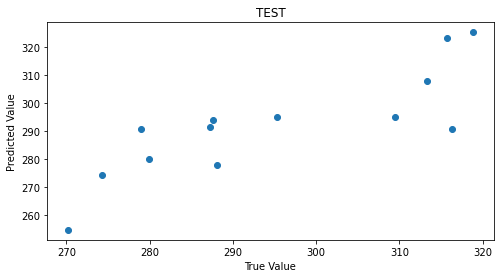

In [128]:
plt.scatter(y_test, m_lasso.predict(X_test))
plt.title('TEST');
plt.xlabel('True Value')
plt.ylabel('Predicted Value');

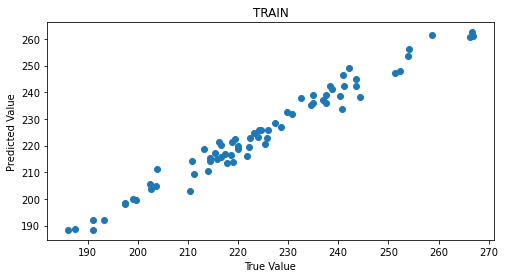

In [129]:
plt.scatter(y_train, m_lasso.predict(X_train))
plt.title('TRAIN');
plt.xlabel('True Value')
plt.ylabel('Predicted Value');

In [133]:
# PREDICT

# Se realiza la predicción sobre la base previa a la predicción. 
# Para valores previos a 2014, donde hay nulos, se llenará con ceros (solo para que no falle la predicción)
dset_trn_tst['price_predicted'] = m_lasso.predict(dset_trn_tst[features].fillna(0))

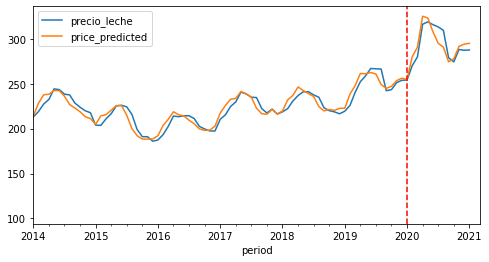

In [135]:
dset_trn_tst[['precio_leche','price_predicted']].plot()
plt.xlim('2014-1','2021-3')
plt.axvline('2020', linestyle='--', color='red')

- La linea roja es el punto que separa el train del test.
- La performance del dato predicho se ve relativamente bueno. La predicción sigue la tendencia y estacionalidad de la curva original

<AxesSubplot:>

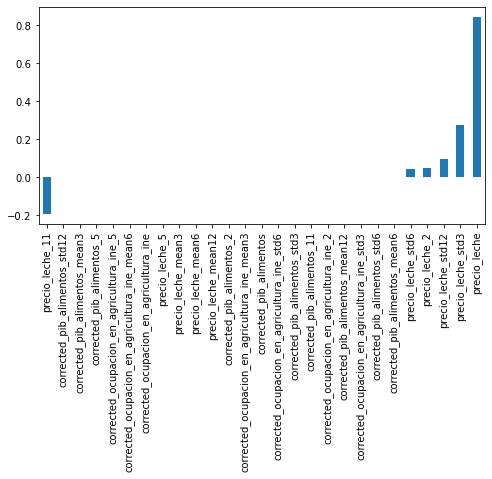

In [136]:
# Evaluación de coeficientes
coefficients = {x:y for x, y in zip(features, m_lasso.coef_)}

pd.Series(coefficients).sort_values().plot(kind='bar')

__EVALUACIÓN__
- Utilizamos como test solo del 2020 en adelante para poder utilizar más datos en el entrenamiento.
- La predicción está funcionando relativamente bien. El error de test (RMSE) va alrededor de 10.8, lo que es aceptable
- Lo anterior podría mejorar si es que contaramos con datos reales en los últimos meses. Dado que no los tuvimos, fue necesario imputar valores con la regla de 3 simple.
- Aparentemente los coeficientes más importantes van hacia los features del precio de la leche (variable autoregresiva). Los otros features parecen tener coeficientes pequeños. Esto es razonable, dado que estas series están en una escala bastante elevada.


## Prediccion del mes siguiente

In [141]:
dset_predict[features]

precio_leche  corrected_pib_alimentos  \
period                                           
2021-02        295.24             3.793803e+08   

         corrected_ocupacion_en_agricultura_ine  precio_leche_2  \
period                                                            
2021-02                            5.943109e+08          287.29   

         precio_leche_5  precio_leche_11  precio_leche_mean3  \
period                                                         
2021-02          278.99           279.88          290.043333   

         precio_leche_std3  precio_leche_mean6  precio_leche_std6  \
period                                                              
2021-02           4.503114             285.255           7.432391   

         precio_leche_mean12  precio_leche_std12  corrected_pib_alimentos_2  \
period                                                                        
2021-02           297.086667           16.565448               3.829789e+08   

         corrected_pib_alimentos_5  corrected_pib_alimentos_11  \
period                                                           
2021-02                334311036.0                 397765588.0   

         corrected_pib_alimentos_mean3  corrected_pib_alimentos_std3  \
period                                                                 
2021-02                   3.892691e+08                  1.412644e+07   

         corrected_pib_alimentos_mean6  corrected_pib_alimentos_std6  \
period                                                                 
2021-02                   3.784743e+08                  2.358086e+07   

         corrected_pib_alimentos_mean12  corrected_pib_alimentos_std12  \
period                                                                   
2021-02                    3.725246e+08                   2.096360e+07   

         corrected_ocupacion_en_agricultura_ine_2  \
period                                              
2021-02                              5.666221e+08   

         corrected_ocupacion_en_agricultura_ine_5  \
period                                              
2021-02                               476652159.0   

         corrected_ocupacion_en_agricultura_ine_mean3  \
period                                                  
2021-02                                  5.855343e+08   

         corrected_ocupacion_en_agricultura_ine_std3  \
period                                                 
2021-02                                 1.639251e+07   

         corrected_ocupacion_en_agricultura_ine_mean6  \
period                                                  
2021-02                                  5.442290e+08   

         corrected_ocupacion_en_agricultura_ine_std6  
period                                                
2021-02                                 4.884442e+07

In [142]:
m_lasso.predict(dset_predict[features])

array([299.81687235])

In [143]:
dset_predict[features]['precio_leche']

period
2021-02    295.24
Freq: M, Name: precio_leche, dtype: float64

- El valor predicho para el siguiente mes es de __299.8168__. Partiendo del precio actual de 295.24. La variación no es excesiva y si entra dentro del rango de lo posible.

## Evaluación calificada

¿Qué datos adicionales te gustaría tener?¿Qué datos son necesarios para que este
modelo funcione/mejore las métricas?
- Para empezar, la misma data, con una mejor calidad, pudo sumar bastante:
    - Primero que nada, hubiera sido adecuado que los datos bancarios vengan en la escala correcta para estar seguros de trabajar con los datos adecuados.
    - Adicionalmente, la información debió estar más completa. Tanto los datos de precipitaciones como los datos bancarios no tienen registros en los periodos más recientes. De esta manera, nuestra predicción se haría con nulos. Se pudo imputar valores que tenían sentido, sin embargo, los datos reales hubieran sumado más. Estas curvas no fueron priorizadas en nuestros análisis, quizá los valores reales si lo hubieran hecho.
- Respecto a datos adicionales, los siguientes pudieron sumar:
    - Volumen de producción de leche y productos derivados (queso, yogurt, etc)
    - Volumen de producción de productos que reemplacen la leche
    - Precio de productos competidores
    - Precio de productos aliados (ej: cereal, si ese precio se redujera, más gente podría comprar leche, lo que subiría su precio)
    - Crecimiento demográfico (niños) y curvas de nacimientos
    - Inflación mensual de productos
    - Precio de la canasta básica
    - Porcentaje de empleabilidad
- Si bien no estoy seguro de su confiabilidad, se ha notado que las variables que mejor performaban eran aquellas que tenían relación más directa con la producción alimentaria. Por ello estas variables podrían estar dentro de las priorizadas.


• ¿Cómo evalúas el resultado del modelo?¿Qué métricas tiene sentido mirar?
- Para problemaas de Regresión valdría mirar el RMSE, que es una medida de dispersión (qué tanto nos equivocamos). Quizá también se pueda usar el MAPE que mide el error porcentual, o el R2 que mide el grado de ajuste. Se decidió ir por el RMSE porque se hizo fácil para comparar el rendimiento versus otros modelos.


• ¿Para qué aplicaciones puede servir un modelo de este tipo? En particular, ¿Cómo
podría ayudar a combatir el cambio climático?
- Un modelo de este tipo podría servir para mercados de derivados financieros (swaps, futuros, etc). Pues conocer el precio de un comodity a futuro puede ayudar a tomar medidas financieras tempranas para obtener una rentabilidad.
- Para temas logísticos. Si el precio va a subir, uno puede decidir comprar y abastecerse. Si el precio fuera a bajar, podría vender su inventario lo más pronto posible.
- Respecto al cambio climático. Modelos de este tipo podrían mostrar cómo las cosechas se reducirán en el tiempo, el número de hectareas que se quemarán en años futuros, el volumen reducido futuro en zonas desérticas, así como el incremento de mm de lluvias en zonas de riesgo. Una vez modelados esos escenarios, se puede buscar sentar conciencia en personas, empresas y gobiernos para que estas proyecciones se controlen.

# END